# Analysis on Wine Ratings and Price Through Machine Learning

### Authors: Emmeline Tsen, Jonathan Gee, Matt DiPietro, Sindhuja Ramini


As a new business, we only have a certain amount of grapes to produce new wine. Using the [wine rating dataset from Kaggle](https://www.kaggle.com/zynicide/wine-reviews#winemag-data-130k-v2.csv), we explored factors that affect the rating of wines and tried to create systems to find highly rated wines for customers to buy. We used k-means clustering, GMM, linear regression, logistic regression, decision tree, random forest, and naive bayes algorithms to analyze our data. We augmented our data using the [US wildfire data](https://www.kaggle.com/rtatman/188-million-us-wildfires) and [California temperature and precipitation data](https://wrcc.dri.edu/Climate/Tracker/CA/) to find latent variables which may have affected the ratings of the wines. Using this new information, we wanted to predict the cost of the new wine that would be on the market based on the price of similar types of wine for a given location and vintage. 

As a consumer new to drinking wine, we wanted to know the types of wine rated best given its vintage. That way, when we are looking at bottles of wines in stores, we would know whether a specific bottle was rated well.





## Imports and Helper Functions

In [0]:
#basic data management libraries
import pandas as pd
import numpy as np
import pylab as pl
import re
from urllib.request import urlopen
import requests
from requests import get
import time
from time import sleep
from random import randint

#algorithms used
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import mixture
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import treej
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from bs4 import BeautifulSoup


#helper libraries to take metrics and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.utils.multiclass import unique_labels
from scipy.spatial.distance import cdist

#libraries to visualize data
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
%matplotlib inline

In [0]:
# Helper function to get the top x in col from data from each cluster

# example usage: get_top_x_per_cluster(x, 'points', data, labels, n)
# x = the top number 'x' from each cluster
# col = the column with an attribute about the dataset
# data = the dataframe with the entire datset
# clusters = the clusters of each point
# n = the number of clusters formed using for k-means

def get_top_x_per_cluster(x, col, data, clusters, n):
    top_lists = [dict() for i in range(n)]
    c = 0
    
    for index, row in data.iterrows():
        i = clusters[c]
        c += 1
        if row[col] in top_lists[i]:
            top_lists[i][row[col]] += 1
        else:
             top_lists[i][row[col]] = 1
    
    print("\nTop", x, col, 'in each cluster')
    for i in range(n):
        print("\nCluster ", i)
        sorted_list = sorted(top_lists[i].items(), key=lambda kv: kv[1])
        sorted_list = list(reversed(sorted_list))
        for y in range(x):
            if(y < len(sorted_list)):
                print(sorted_list[y])
    return
    

In [0]:
# Helper function to count the number of samples in each cluster

def label_count(labels):

	lab_count = dict()

	for x in labels:
		if x in lab_count:
			lab_count[x] += 1
		else:
			lab_count[x] = 1

	print(lab_count)

	return

In [0]:
# Helper function to print confusion matrix and other stats on each model

def model_stats(y_true, y_pred):
    
    conf_mat = confusion_matrix(y_true, y_pred)
    sns.set(font_scale=1.2)#for label size
    sns.heatmap(conf_mat, annot=True,annot_kws={"size": 16},)# font size

    
    stats = precision_recall_fscore_support(y_true, y_pred, average = 'weighted')
    print('\nprecision')
    print(stats[0])
    print('recall')
    print(stats[1])
    print('f1 score')
    print(stats[2])
    print('\n')
    
    



# Data Cleaning and Transformation

In order to feed our data into the different models we had to follow various data preprocessing steps. The notebooks for Data Cleaning can be found[ here ](https://github.com/jems2019/CMPE257/blob/master/Data%20Cleaning/dropna_3_primary_column.ipynb). To transform our data,  we had to convert categorical attributes into numerical attributes and extracted out the vintage of each wine from the title of the wine. We also normalized all our numerical features to help some algorthims. 

# K Means


In [0]:
# Load the cleaned wine data into dataframe

""" 
    Information of cleaned dataset:
    
    - Province and Variety of wine is transfomed from a categorical attribute to numerical attribute
    - Vintage of wine is extracted from the title of each wine
    - Rows were removed if there were null values present within each of the three attributes (Province, Variety, Vintage)
    - Dataset size was reduced from 125,000 rows to 22,000 rows
    
"""
url = 'https://raw.githubusercontent.com/jems2019/CMPE257/master/data/'
data_set = '3column_clean.csv'

data = pd.read_csv(url+data_set)
data.dropna(subset = ['points', 'price'], inplace = True)
print(data.shape)
data.head()

(116591, 17)


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,province_id,variety_numerical,vintage
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,1,450,2011
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2,436,2013
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,3,479,2013
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2,440,2012
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,4,590,2011


In [0]:
# Extract data for clustering and analysis 

clustering_data = data.loc[:,['province_id','variety_numerical','vintage']]
clustering_data.head()

,province_id,variety_numerical,vintage
1,1,450,2011
2,2,436,2013
3,3,479,2013
4,2,440,2012
5,4,590,2011


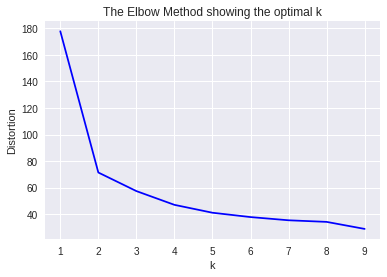

In [0]:
# Determine k using elbow method
# Elbow method based on non normalized data

X = np.array(list(zip(data.loc[:,'province_id'], data.loc[:,'variety_numerical']))).reshape(len(data.loc[:,'province_id']),2)

# k means determine k
distortions=[]
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()



Clusters:
{1: 37970, 5: 17067, 7: 7697, 0: 32000, 4: 10819, 2: 8083, 6: 2945, 3: 10}


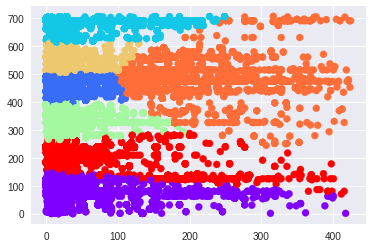

In [0]:
# First pass at trying to find informative clusters 
# Set k=8 for k-means clustering 
# using the non normalized data for province, vintage, and variety
n = 8

cluster = KMeans(n_clusters = n, random_state = 0).fit(clustering_data)

labels = cluster.labels_
print("\n\nClusters:")
label_count(labels)
#data.loc[:,['province_id','variety_numerical','vintage']]


# Plot for the original 1st pass of K_means clustering using raw data
plt.scatter(data.loc[:,'province_id'], data.loc[:,'variety_numerical'], c=labels, cmap='rainbow')    
plt.show()

In [0]:
# Normalizing province id between 1 and 0 
data['norm_province_id'] = abs((data.province_id - data.province_id.min()) / (data.province_id.max()))
# Normalizing variety (numerical) between 1 and 0 
data['norm_variety_numerical'] = abs((data.variety_numerical - data.variety_numerical.min()) / (data.variety_numerical.max()))

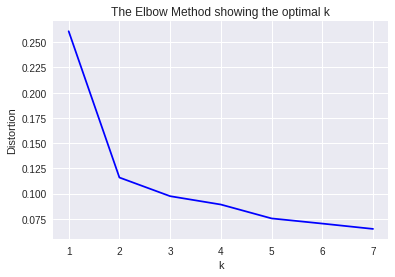

In [0]:
# Determine k using elbow method
# Elbow method based on Normalized data

X = np.array(list(zip(data.loc[:,'norm_province_id'], data.loc[:,'norm_variety_numerical']))).reshape(len(data.loc[:,'norm_province_id']),2)

# k means determine k
distortions=[]
K = range(1,8)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

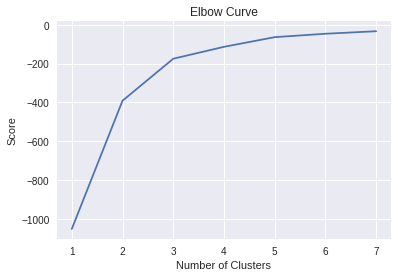

In [0]:
# Create an elbow curve using the pylab library 
# Elbow curve will be for province and variety
# Elbow data based on normalized data

Y = data[['norm_province_id']]
X = data[['norm_variety_numerical']]

# Setting a range between 1 to 20 
Nc = range(1, 8)

kmeans = [KMeans(n_clusters=i) for i in Nc]

# Score variable denotes the percentage of variance explained by the number of clusters
score = [kmeans[i].fit(Y).score(Y) for i in range(len(kmeans))]

pl.plot(Nc,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [0]:
# Gathering normalized data to prepare for clustering
# 2nd pass at K_means clustering using the normalized data instead of non normalized data to help with outliers
clustering_norm_data = data.loc[:,['norm_province_id','norm_variety_numerical']]
clustering_norm_data.head()

,norm_province_id,norm_variety_numerical
1,0.002353,0.638810
2,0.004706,0.618980
3,0.007059,0.679887
4,0.004706,0.624646
5,0.009412,0.837110




Clusters:
{2: 54979, 0: 16109, 1: 42033, 3: 3470}


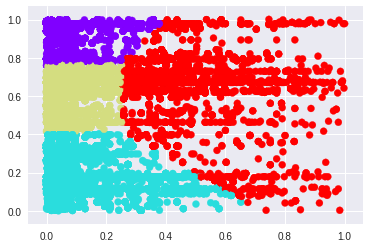

In [0]:
# generating the K-Means clusters and setting k = 4 based on elbow method above
n = 4

cluster = KMeans(n_clusters = n, random_state = 0).fit(clustering_norm_data)

labels = cluster.labels_
print("\n\nClusters:")
label_count(labels)
#data.loc[:,['province_id','variety_numerical','vintage']]

# Scatter plot of the normalized k-means clustering of points and price
plt.scatter(data.loc[:,'norm_province_id'], data.loc[:,'norm_variety_numerical'], c=labels, cmap='rainbow')    
plt.show()

In [0]:
# Get top 3 province ids from each cluster formed
get_top_x_per_cluster(3, 'province', data, labels, n)

# Get top 3 varieties from each cluster formed
get_top_x_per_cluster(3, 'variety', data, labels, n)

# Get top 3 vintage from each cluster formed
get_top_x_per_cluster(3, 'vintage', data, labels, n)


Top 3 province in each cluster

Cluster  0
('California', 5931)
('Northern Spain', 2642)
('Washington', 1641)

Cluster  1
('California', 13834)
('Washington', 3707)
('Bordeaux', 3684)

Cluster  2
('California', 15670)
('Tuscany', 4601)
('Oregon', 3969)

Cluster  3
('Dão', 215)
('Wachau', 138)
('Cachapoal Valley', 104)

Top 3 variety in each cluster

Cluster  0
('Syrah', 3920)
('Zinfandel', 2680)
('White Blend', 1944)

Cluster  1
('Chardonnay', 10755)
('Cabernet Sauvignon', 9292)
('Bordeaux-style Red Blend', 5307)

Cluster  2
('Pinot Noir', 12392)
('Red Blend', 7842)
('Riesling', 4600)

Cluster  3
('Red Blend', 390)
('Riesling', 337)
('Portuguese Red', 329)

Top 3 vintage in each cluster

Cluster  0
(2013, 2049)
(2012, 1985)
(2011, 1683)

Cluster  1
(2013, 5460)
(2014, 5452)
(2012, 5199)

Cluster  2
(2014, 7338)
(2013, 7241)
(2012, 7165)

Cluster  3
(2014, 399)
(2013, 396)
(2012, 349)


## Analysis 

Here, we use K-means clustering to cluster our data based on the province, variety and vintage of each wine. We converted the categorical data to numerical data by applying numberical labels to the provinces and varieties, and extracted the vintage of each wine from the wine's title. We then normalized these values to run K-means clustering on our data. To find the optimal number of clusters, we used the elbow method and found 4 to be the best. 

From our resulting clusters, we can see that for the province, 3 out of the 4 clusters have California as the top province. This is because California is the most popular province in this dataset with 36247 entries, approximately 28% of our dataset. 

The clustering did split the varieties though. The vintage of the wine also does not seem to break into clusters very well because there are only a few different vintages compared to the amount of samples we have. 

Clustering this way does not seem to have an effect on the ratings of the wine though, as each cluster has the same top 3 scores. Same with the price of the wine. This is due to the majority of the wine having a score of ~88 and a price of $20. 

In [0]:
# Retrieve Wine Enthusiast Point Rating and Price column from dataset

data.dropna(subset=['points','price'],inplace=True)
clustering_data = data.loc[:,['points','price']]
clustering_data.head()

,points,price
1,87,15.0
2,87,14.0
3,87,13.0
4,87,65.0
5,87,15.0


In [0]:
# Normalizing price between 1 and 0 
data['norm_price'] = abs((data.price - data.price.min()) / (data.price.max()))
# Normalizing points(rating) between 1 and 0 
data['norm_points'] = abs((data.points - data.points.min()) / (data.points.max()))

In [0]:
# Gathering normalized data to prepare for clustering
clustering_norm_data = data.loc[:,['norm_price','norm_points']]
clustering_norm_data.head()

,norm_price,norm_points
1,0.003333,0.07
2,0.003030,0.07
3,0.002727,0.07
4,0.018485,0.07
5,0.003333,0.07


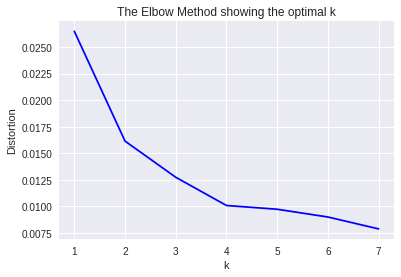

In [0]:
# Determine k using elbow method

X = np.array(list(zip(data.loc[:,'norm_price'], data.loc[:,'norm_points']))).reshape(len(data.loc[:,'norm_price']),2)

# k means determine k
distortions=[]
K = range(1,8)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


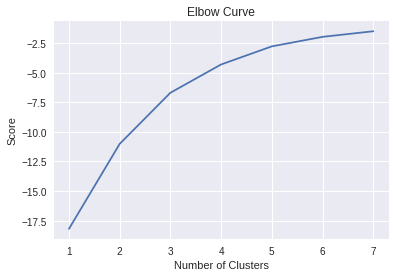

In [0]:
# Create an elbow curve using the pylab library 
# Elbow curve will be for price and points

Y = data[['norm_price']]
X = data[['norm_points']]

# Setting a range between 1 to 20 
Nc = range(1, 8)

kmeans = [KMeans(n_clusters=i) for i in Nc]

# Score variable denotes the percentage of variance explained by the number of clusters
score = [kmeans[i].fit(Y).score(Y) for i in range(len(kmeans))]

pl.plot(Nc,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()




Clusters:
{0: 30672, 1: 30698, 2: 19885, 4: 34878, 3: 458}


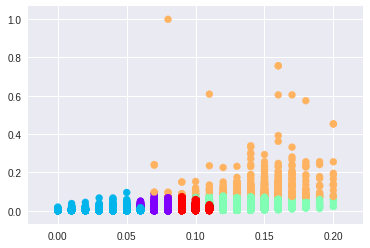

In [0]:
# Through both graphs from the elbow curve, k=4 appears to be the elbow of the curve
# Using k-means clustering on dataset based on points and price for each wine.

n = 5

cluster = KMeans(n_clusters = n, random_state = 0).fit(clustering_norm_data)

labels = cluster.labels_
print("\n\nClusters:")
label_count(labels)

# Plotting results from k-means clustering based on points and price

plt.scatter(data.loc[:,'norm_points'], data.loc[:,'norm_price'], c=labels, cmap='rainbow')    
plt.show()

In [0]:
# Get top 3 points from each cluster formed
get_top_x_per_cluster(3, 'points', data, labels, n)

# Get top 3 price from each cluster formed
get_top_x_per_cluster(3, 'price', data, labels, n)


Top 3 points in each cluster

Cluster  0
(88, 15383)
(87, 15067)
(86, 222)

Cluster  1
(86, 11001)
(85, 8496)
(84, 5820)

Cluster  2
(92, 8663)
(93, 5782)
(94, 3321)

Cluster  3
(95, 118)
(94, 77)
(96, 69)

Cluster  4
(90, 13918)
(89, 10886)
(91, 10073)

Top 3 price in each cluster

Cluster  0
(20.0, 2377)
(15.0, 2115)
(25.0, 1789)

Cluster  1
(15.0, 2579)
(10.0, 2451)
(12.0, 2297)

Cluster  2
(50.0, 1167)
(40.0, 924)
(60.0, 920)

Cluster  3
(300.0, 31)
(250.0, 24)
(450.0, 24)

Cluster  4
(20.0, 2107)
(25.0, 2087)
(30.0, 1897)


## Analysis

Here, we cluster based on the normalized points and price of the wine. Here the clusters are relatively well defined. There is a relationship between the price of the wine and the rating, as shown by the clusters. More expensive wines generally have a higher rating than the cheaper wines. 

### K Means with our final dataset

In [0]:
url = 'https://raw.githubusercontent.com/jems2019/CMPE257/master/data/'
data_set = 'wine_fire_soup.csv'

data = pd.read_csv(url+data_set)
print(data.shape)
data.head()

(3278, 41)


,Unnamed: 0,Unnamed: 0.1,country,description,designation,points,price,province,region_1,region_2,...,norm_sum_fire_size_current,mean_temp,mean_rain,norm_temp,norm_rain,ratings,reviews,norm_ratings,norm_reviews,review_words
0,1,1,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,...,0.002502,57.042925,23.084964,0.176770,0.192200,4.0,117.0,0.4,0.060385,44
1,4,4,US,There are intriguing touches to the nose of th...,Golden Horn,86,26.0,California,Santa Ynez Valley,Central Coast,...,0.010616,60.220294,12.206211,0.226633,0.074369,4.0,262.0,0.4,0.135867,33
2,10,10,US,"This blend of Sangiovese, Malbec, Cabernet Sau...",Siena,88,23.0,California,Sonoma County,Sonoma,...,0.002549,63.720922,19.575900,0.281570,0.154192,3.5,257.0,0.3,0.133264,36
3,17,17,US,"Thick and brooding, this dark, sweetly tannic ...",K Block,91,85.0,California,Spring Mountain District,Napa,...,0.003793,61.338887,5.535779,0.244188,0.002119,5.0,3.0,0.6,0.001041,36
4,18,18,US,"Cooked cranberry is spiced with anise, pepperc...",Guidotti Vineyard,91,64.0,California,Santa Lucia Highlands,Central Coast,...,0.004112,58.685722,5.340118,0.202551,0.000000,4.0,18.0,0.4,0.008850,42




Clusters:
{1: 917, 0: 1339, 3: 822, 2: 200}


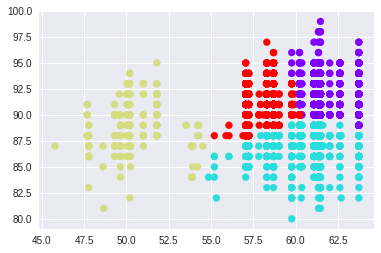

In [0]:
# generating the K-Means clusters and setting k = 4 based on elbow method above
clustering_norm_data = data.loc[:,['mean_temp','points']]
clustering_norm_data.head()
n = 4

cluster = KMeans(n_clusters = n, random_state = 0).fit(clustering_norm_data)

labels = cluster.labels_
print("\n\nClusters:")
label_count(labels)
#data.loc[:,['province_id','variety_numerical','vintage']]

# Scatter plot of the normalized k-means clustering of points and price
plt.scatter(data.loc[:,'mean_temp'], data.loc[:,'points'], c=labels, cmap='rainbow')    
plt.show()



Clusters:
{1: 1448, 0: 1198, 3: 545, 2: 87}


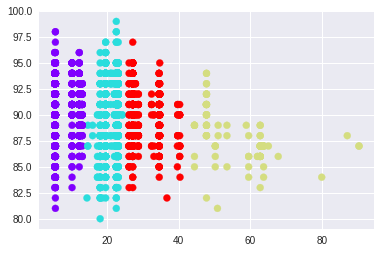

In [0]:
# generating the K-Means clusters and setting k = 4 based on elbow method above
clustering_norm_data = data.loc[:,['mean_rain','points']]
clustering_norm_data.head()
n = 4

cluster = KMeans(n_clusters = n, random_state = 0).fit(clustering_norm_data)

labels = cluster.labels_
print("\n\nClusters:")
label_count(labels)
#data.loc[:,['province_id','variety_numerical','vintage']]

# Scatter plot of the normalized k-means clustering of points and price
plt.scatter(data.loc[:,'mean_rain'], data.loc[:,'points'], c=labels, cmap='rainbow')    
plt.show()

# Gaussian Mixture Modeling

In [0]:

# Load the cleaned wine data into dataframe
""" 
    Information of cleaned dataset:
    
    - Province and Variety of wine is transfomed from a categorical attribute to numerical attribute
    - Vintage of wine is extracted from the title of each wine
    - Rows were removed if there were null values present within each of the three attributes (Province, Variety, Vintage)
    - Dataset size was reduced from 125,000 rows to 22,000 rows
    
"""
url = 'https://raw.githubusercontent.com/jems2019/CMPE257/master/data/'
data_set = '3column_clean.csv'

data = pd.read_csv(url+data_set)
data.dropna(subset = ['points', 'price'], inplace = True)
print(data.shape)
data.head()

(116591, 17)


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,province_id,variety_numerical,vintage
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,1,450,2011
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2,436,2013
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,3,479,2013
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2,440,2012
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,4,590,2011


In [0]:
# Extract data for clustering and analysis 

clustering_data = data.loc[:,['province_id','variety_numerical','vintage']]
clustering_data.head()

,province_id,variety_numerical,vintage
1,1,450,2011
2,2,436,2013
3,3,479,2013
4,2,440,2012
5,4,590,2011




Clusters:
{5: 21055, 6: 28076, 1: 28094, 7: 23284, 3: 5899, 0: 9998, 4: 175, 2: 10}


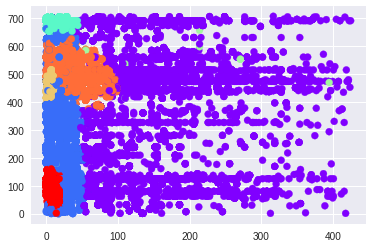

In [0]:
# Set n=8 for GMM
# n is taken from elbow method when applying k-means clustering
n = 8

gmm = mixture.GaussianMixture(n_components=n, random_state = 0).fit(clustering_data)
labels = gmm.predict(clustering_data)

print("\n\nClusters:")
label_count(labels)
#data.loc[:,['province_id','variety_numerical','vintage']]

# Plot for the original 1st pass of GMM clustering using raw data

plt.scatter(data.loc[:,'province_id'], data.loc[:,'variety_numerical'], c=labels, cmap='rainbow')    
plt.show()

In [0]:
# Get top 3 province ids from each cluster formed
get_top_x_per_cluster(3, 'province', data, labels, n)

# Get top 3 varieties from each cluster formed
get_top_x_per_cluster(3, 'variety', data, labels, n)

# Get top 3 vintage from each cluster formed
get_top_x_per_cluster(3, 'vintage', data, labels, n)


Top 3 province in each cluster

Cluster  0
('Loire Valley', 639)
('Niederösterreich', 327)
('Wachau', 305)

Cluster  1
('California', 4197)
('Piedmont', 2959)
('Burgundy', 2506)

Cluster  2
('California', 10)

Cluster  3
('California', 3253)
('Northern Spain', 393)
('Washington', 334)

Cluster  4
('Port', 24)
('Tuscany', 22)
('California', 17)

Cluster  5
('California', 12718)
('Oregon', 3659)
('Alsace', 1285)

Cluster  6
('Tuscany', 3952)
('Washington', 2882)
('California', 2664)

Cluster  7
('California', 12576)
('Bordeaux', 3677)
('Washington', 3057)

Top 3 variety in each cluster

Cluster  0
('Grüner Veltliner', 992)
('Chardonnay', 869)
('Cabernet Sauvignon', 527)

Cluster  1
('Chardonnay', 3064)
('Merlot', 2810)
('Malbec', 2521)

Cluster  2
('Cabernet Sauvignon', 6)
('Bordeaux-style Red Blend', 3)
('Sauvignon Blanc', 1)

Cluster  3
('Zinfandel', 2507)
('White Blend', 1586)
('Viognier', 830)

Cluster  4
('Port', 24)
('Champagne Blend', 17)
('Red Blend', 15)

Cluster  5
('Pinot Noi

##  Analysis - Applying GMM without Data Normalization

We applied the GMM algorithm based on the province, variety and vintage of each wine without normalizing the dataset (province, variety, vintage). Within the top clusters for province, the resulting clusters returned California in 7 out of 8 of these clusters. This is because California is the most popular province in this dataset with 36247 entries, approximately 28% of our dataset. In addition, we also see that several vintages were spread across different clusters because there was only a few different vintages compared to the amount of samples. For example, wines with vintage of 2013 were in 6 out of 8 of the clusters. The clusters formed based on the top varieties did have different types of wines within each of the clusters. 

The scatter plot with n=8 using the GMM algorithm shows that there are some provinces with many different types of wines. It also showed that outside some of the smaller clusters formed, the biggest cluster had all different types of wines coming from many different provinces. This is representative of what is seen from the clusters because the dataset had more data than other provinces.

In [0]:
# Normalizing province id between 1 and 0 
data['norm_province_id'] = abs((data.province_id - data.province_id.min()) / (data.province_id.max()))

# Normalizing variety (numerical) between 1 and 0 
data['norm_variety_numerical'] = abs((data.variety_numerical - data.variety_numerical.min()) / (data.variety_numerical.max()))

# Normalizing province id between 1 and 0 
data['norm_vintage'] = abs((data.vintage - data.vintage.min()) / (data.vintage.max()))

# Normalizing price between 1 and 0 
data['norm_price'] = abs((data.price - data.price.min()) / (data.price.max()))

# Normalizing points(rating) between 1 and 0 
data['norm_points'] = abs((data.points - data.points.min()) / (data.points.max()))

In [0]:
# Gathering normalized data to prepare for clustering
# 2nd pass at GMM clustering using the normalized data instead of non normalized data to help with outliers
clustering_norm_data = data.loc[:,['norm_province_id','norm_variety_numerical']]
clustering_norm_data.head()

,norm_province_id,norm_variety_numerical
1,0.002353,0.638810
2,0.004706,0.618980
3,0.007059,0.679887
4,0.004706,0.624646
5,0.009412,0.837110




Clusters:
{0: 31852, 2: 33075, 1: 29715, 3: 21949}


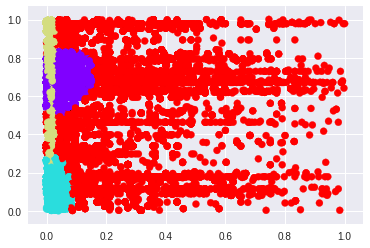

In [0]:
# generating the GMM clusters and setting n = 4 based on elbow method from K-means
n = 4

gmm = mixture.GaussianMixture(n_components=n, random_state = 0).fit(clustering_norm_data)
labels = gmm.predict(clustering_norm_data)

print("\n\nClusters:")
label_count(labels)
#data.loc[:,['province_id','variety_numerical','vintage']]

# Scatter plot of the normalized k-means clustering of points and price
plt.scatter(data.loc[:,'norm_province_id'], data.loc[:,'norm_variety_numerical'], c=labels, cmap='rainbow')    
plt.show()

In [0]:
# Get top 3 province ids from each cluster formed
get_top_x_per_cluster(3, 'province', data, labels, n)

# Get top 3 varieties from each cluster formed
get_top_x_per_cluster(3, 'variety', data, labels, n)

# Get top 3 vintage from each cluster formed
get_top_x_per_cluster(3, 'vintage', data, labels, n)


Top 3 province in each cluster

Cluster  0
('Tuscany', 4584)
('Oregon', 3833)
('Washington', 3731)

Cluster  1
('California', 12752)
('Bordeaux', 3678)
('Washington', 3168)

Cluster  2
('California', 22683)
('Northern Spain', 3700)
('Mendoza Province', 1919)

Cluster  3
('Washington', 1610)
('Loire Valley', 1536)
('Veneto', 1126)

Top 3 variety in each cluster

Cluster  0
('Red Blend', 5634)
('Pinot Noir', 4790)
('Rosé', 2231)

Cluster  1
('Chardonnay', 9490)
('Cabernet Sauvignon', 8641)
('Bordeaux-style Red Blend', 5041)

Cluster  2
('Pinot Noir', 7079)
('Zinfandel', 2623)
('Syrah', 2109)

Cluster  3
('Merlot', 1506)
('Chardonnay', 1319)
('White Blend', 1316)

Top 3 vintage in each cluster

Cluster  0
(2012, 4068)
(2014, 3867)
(2013, 3844)

Cluster  1
(2014, 3991)
(2013, 3952)
(2012, 3770)

Cluster  2
(2013, 4862)
(2012, 4475)
(2014, 4194)

Cluster  3
(2014, 2794)
(2013, 2488)
(2015, 2396)


## Analysis - GMM with Normalized Data
After applying the GMM algorithm with k=4 (from the elbow method with k-means) and our normalized dataset, the scatter plot shows that more distinct clusters were formed. It shows that certain provinces countained more specific varieties of wine. Similar to the scatter plot utilizing GMM on our unnormalized data, the plot also shows that there are still some specific provinces producing a larger varitety of wine. Even after using the normalized dataset to apply GMM, the cluster analysis still shows the same provinces in different clusters and the same vintages spread across different clusters. Although the data has been normalized, the volume of specific provinces (such as Washington and California) do not change.

In [0]:
filtered_data = data.query('variety == "Chardonnay"')
filtered_data = filtered_data.query('vintage <= 2018 and vintage >= 1900')



clustering_norm_data = filtered_data.loc[:,['norm_vintage', 'norm_points', 'norm_price']]
print(filtered_data.shape)
clustering_norm_data.head()

(10808, 22)


,norm_vintage,norm_points,norm_price
14,0.119722,0.07,0.002424
55,0.119444,0.05,0.007879
56,0.119444,0.05,0.003030
64,0.120139,0.06,0.006061
65,0.120139,0.06,0.003333




Clusters:
{0: 3421, 3: 440, 1: 4818, 4: 1857, 2: 272}


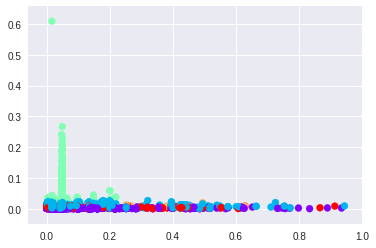

In [0]:
# generating the GMM clusters and setting n = 4 based on elbow method from K-means
n = 5

gmm = mixture.GaussianMixture(n_components=n, random_state = 0).fit(clustering_norm_data)
labels = gmm.predict(clustering_norm_data)

print("\n\nClusters:")
label_count(labels)

# Scatter plot of the normalized k-means clustering of points and price
plt.scatter(filtered_data.loc[:,'norm_province_id'], filtered_data.loc[:,'norm_price'], c=labels, cmap='rainbow')    
plt.show()

(3043, 22)


Clusters:
{0: 1189, 3: 820, 2: 194, 1: 811, 4: 29}


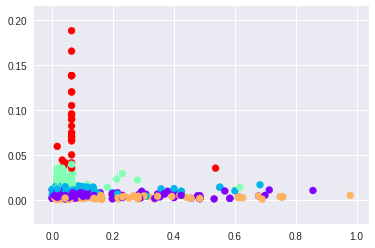

In [0]:
filtered_data = data.query('variety == "Merlot"')
filtered_data = filtered_data.query('vintage <= 2018 and vintage >= 1900')



clustering_norm_data = filtered_data.loc[:,['norm_vintage', 'norm_points', 'norm_price']]
print(filtered_data.shape)
clustering_norm_data.head()

# generating the GMM clusters and setting n = 4 based on elbow method from K-means
n = 5

gmm = mixture.GaussianMixture(n_components=n, random_state = 0).fit(clustering_norm_data)
labels = gmm.predict(clustering_norm_data)

print("\n\nClusters:")
label_count(labels)

# Scatter plot of the normalized k-means clustering of points and price
plt.scatter(filtered_data.loc[:,'norm_province_id'], filtered_data.loc[:,'norm_price'], c=labels, cmap='rainbow')    
plt.show()


## Analysis - GMM with Filtered Wine Variety 

We filtered our dataset and applied GMM on both of the datasets separately. We first filtered it by retrieving all the wine review data for Chardonnays (a common white wine) and another to retrieve all the wine review data for Merlots (a common red wine). Both scatter plots representing the data based on province and price showed that there was one particular province that had wine prices ranging from low to high cost. The top 3 provinces in each cluster had California in it, verifying the scatter plot representation of one province having a large range of wine prices.

In [0]:
filtered_data = data.query('not province == "California"')
filtered_data = filtered_data.query('vintage <= 2018 and vintage >= 1900')



clustering_norm_data = filtered_data.loc[:,['norm_vintage', 'norm_points', 'norm_price', 'norm_province_id']]
print(filtered_data.shape)
clustering_norm_data.head()


(81084, 22)


,norm_vintage,norm_points,norm_price,norm_province_id
1,0.119583,0.07,0.003333,0.002353
2,0.119861,0.07,0.003030,0.004706
3,0.119861,0.07,0.002727,0.007059
4,0.119722,0.07,0.018485,0.004706
5,0.119583,0.07,0.003333,0.009412




Clusters:
{3: 48387, 0: 24589, 2: 1866, 4: 5343, 1: 899}


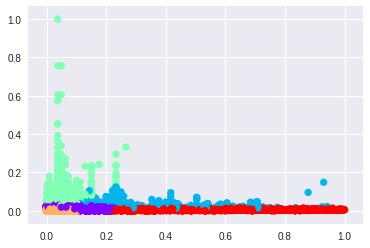

In [0]:
# generating the GMM clusters and setting n = 4 based on elbow method from K-means
n = 5

gmm = mixture.GaussianMixture(n_components=n, random_state = 0).fit(clustering_norm_data)
labels = gmm.predict(clustering_norm_data)

print("\n\nClusters:")
label_count(labels)

# Scatter plot of the normalized k-means clustering of points and price
plt.scatter(filtered_data.loc[:,'norm_province_id'], filtered_data.loc[:,'norm_price'], c=labels, cmap='rainbow')    
plt.show()

## Analysis - GMM with Filtered Data without California Wines 
After applying GMM on a filtered dataset based on specific wine variety, we found that the California wine reviews skewed the data because there are a lot more reviews for California wines than those from other provinces. Therefore, we filtered our dataset to apply GMM on all reviews that were not California wines on the normalized vintage, normalized wine review points, normalized price, and normalized province id. 

The clusters showed that there is a relationship between price and province. For example, it showed that provinces such as Burgundy, Tuscany, and Piedmont had higher wine prices than some of the other provinces. Without the data of California wines impacting the clusters from the dataset, we gain insight about the relationship between price and province from the rest of our dataset.

In [0]:
# Retrieve Wine Enthusiast Point Rating and Price column from dataset

# Gathering normalized data to prepare for clustering
data.dropna(subset=['points','price'],inplace=True)
clustering_norm_data = data.loc[:,['norm_price','norm_points']]
clustering_norm_data.head()

,norm_price,norm_points
1,0.003333,0.07
2,0.003030,0.07
3,0.002727,0.07
4,0.018485,0.07
5,0.003333,0.07




Clusters:
{5: 24312, 3: 12202, 1: 13323, 0: 14687, 2: 25809, 6: 20090, 4: 1130, 7: 5038}


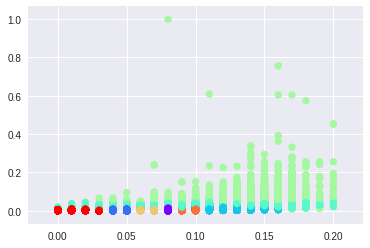

In [0]:
# Through both graphs from the elbow curve, k=5 appears to be the elbow of the curve from our K-means analysis
# Using GMM clustering on dataset based on points and price for each wine.

n = 8

gmm = mixture.GaussianMixture(n_components=n, random_state = 0).fit(clustering_norm_data)
labels = gmm.predict(clustering_norm_data)

print("\n\nClusters:")
label_count(labels)

# Plotting results from GMM clustering based on points and price

plt.scatter(data.loc[:,'norm_points'], data.loc[:,'norm_price'], c=labels, cmap='rainbow')    
plt.show()

In [0]:
# Get top 3 points from each cluster formed
get_top_x_per_cluster(3, 'points', data, labels, n)

# Get top 3 price from each cluster formed
get_top_x_per_cluster(3, 'price', data, labels, n)


Top 3 points in each cluster

Cluster  0
(88, 14687)

Cluster  1
(85, 7889)
(84, 5434)

Cluster  2
(91, 9151)
(92, 7337)
(93, 4557)

Cluster  3
(89, 1484)
(90, 1374)
(92, 1257)

Cluster  4
(94, 230)
(95, 216)
(93, 154)

Cluster  5
(87, 13896)
(86, 10416)

Cluster  6
(90, 10716)
(89, 9374)

Cluster  7
(83, 2537)
(82, 1555)
(81, 601)

Top 3 price in each cluster

Cluster  0
(20.0, 1224)
(25.0, 989)
(15.0, 948)

Cluster  1
(10.0, 1279)
(15.0, 1175)
(12.0, 1124)

Cluster  2
(50.0, 2120)
(60.0, 1597)
(40.0, 1459)

Cluster  3
(75.0, 1005)
(80.0, 841)
(50.0, 763)

Cluster  4
(200.0, 93)
(175.0, 79)
(250.0, 51)

Cluster  5
(15.0, 2147)
(20.0, 1881)
(18.0, 1488)

Cluster  6
(20.0, 1664)
(25.0, 1557)
(30.0, 1290)

Cluster  7
(10.0, 543)
(12.0, 442)
(15.0, 424)


## Analysis - GMM with Normalized points and price

Here, we cluster based on the normalized points and price of the wine for all type of wine from any location. Here the clusters are relatively well defined. They all have prices and points that seem to be in a similar range. There is a relationship between the price of the wine and the rating, as shown by the clusters. We can observe here that more expensive wines generally have a higher rating than the cheaper wines. There seem to be a few outliers where some cheap wines have higher ratings and vice versa.

### GMM with our final dataset

In [0]:
url = 'https://raw.githubusercontent.com/jems2019/CMPE257/master/data/'
data_set = 'wine_fire_soup.csv'

data = pd.read_csv(url+data_set)
print(data.shape)
data.head()

(3278, 41)


,Unnamed: 0,Unnamed: 0.1,country,description,designation,points,price,province,region_1,region_2,...,norm_sum_fire_size_current,mean_temp,mean_rain,norm_temp,norm_rain,ratings,reviews,norm_ratings,norm_reviews,review_words
0,1,1,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,...,0.002502,57.042925,23.084964,0.176770,0.192200,4.0,117.0,0.4,0.060385,44
1,4,4,US,There are intriguing touches to the nose of th...,Golden Horn,86,26.0,California,Santa Ynez Valley,Central Coast,...,0.010616,60.220294,12.206211,0.226633,0.074369,4.0,262.0,0.4,0.135867,33
2,10,10,US,"This blend of Sangiovese, Malbec, Cabernet Sau...",Siena,88,23.0,California,Sonoma County,Sonoma,...,0.002549,63.720922,19.575900,0.281570,0.154192,3.5,257.0,0.3,0.133264,36
3,17,17,US,"Thick and brooding, this dark, sweetly tannic ...",K Block,91,85.0,California,Spring Mountain District,Napa,...,0.003793,61.338887,5.535779,0.244188,0.002119,5.0,3.0,0.6,0.001041,36
4,18,18,US,"Cooked cranberry is spiced with anise, pepperc...",Guidotti Vineyard,91,64.0,California,Santa Lucia Highlands,Central Coast,...,0.004112,58.685722,5.340118,0.202551,0.000000,4.0,18.0,0.4,0.008850,42




Clusters:
{1: 796, 0: 1463, 3: 825, 2: 194}


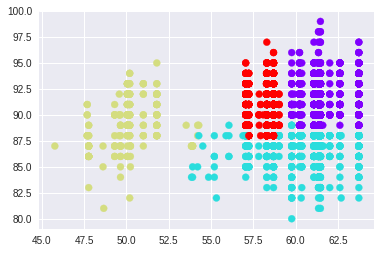

In [0]:
# generating the K-Means clusters and setting k = 4 based on elbow method above
clustering_norm_data = data.loc[:,['mean_temp','points']]
clustering_norm_data.head()
n = 4

cluster = mixture.GaussianMixture(n_components = n, random_state = 0).fit(clustering_norm_data)

labels = cluster.predict(clustering_norm_data)
print("\n\nClusters:")
label_count(labels)
#data.loc[:,['province_id','variety_numerical','vintage']]

# Scatter plot of the normalized k-means clustering of points and price
plt.scatter(data.loc[:,'mean_temp'], data.loc[:,'points'], c=labels, cmap='rainbow')    
plt.show()



Clusters:
{1: 699, 3: 675, 2: 916, 0: 988}


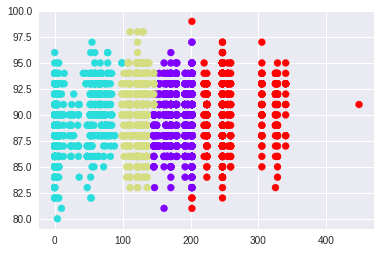

In [0]:
# generating the K-Means clusters and setting k = 4 based on elbow method above
clustering_norm_data = data.loc[:,['total_fires','points']]
clustering_norm_data.head()
n = 4

cluster = mixture.GaussianMixture(n_components = n, random_state = 0).fit(clustering_norm_data)

labels = cluster.predict(clustering_norm_data)
print("\n\nClusters:")
label_count(labels)
#data.loc[:,['province_id','variety_numerical','vintage']]

# Scatter plot of the normalized k-means clustering of points and price
plt.scatter(data.loc[:,'total_fires'], data.loc[:,'points'], c=labels, cmap='rainbow')    
plt.show()

## Clustering Conclusion

In conclusion at this point in the project, we ran our dataset using the GMM algorithm on various subsets and features of the data to observe which clusters made the most sense. After running GMM on the entire dataset we realized that California made up a lot of the data data so when we clustered based on province, variety, and vintage we found that 6/8 clusters all had California. Then we ran it again on the normalized data for province, variety, and variety similarily here again we noticed that the clusters all contain California and Washington because the dataset has high volume for these two provinces. After multiple attempts, we realized we get more meaning out of the the data when we use every Province except California as California was skewing the data. When we ran GMM on the normalized province, vintage, price, and points we got well defined clusters. These clusters showed that there is a realtionship between price and province. 

we have run our data set through data cleaning, normalization, to allow us to run K_Means, Agglomerative, and GMM clustering techniques. Do to the size of the dataset we were un able to run agglomerative clustering. However, looking at the clusters from K_Means and GMM we have gained some valuable insites about our data that helped us refine our perception of the data and what the data is able to tell us. Especially using GMM we relized that our data was heavily biased. Our dataset has about 28% of all data from Califorina. We were hoping to build a recommendation system that could help recommend a new upstart wine maker, what to set the sale price of thier new wine. We were hoping that based on number of different factors such as vintage, type of grape, location we could reliabily recommend what price to set the wine. We realized that becomes an issue because of the bias of the dataset to California. Using clusers majority of our data shows up in a cluser associated with California. Do to this, we relized that is order to get a reliable recommendation for locations that do not have such a large collection of data points, we needed to minimize the amount of data we have from California. By doing this we were able to get a better clustering from locations with less datapoints. We also noticed that while trying to look for correlations in the dataset, we need to start looking for latent variables that are not explicity called out in our dataset. We are currently working on looking for a second dataset that we can use to enrich our current dataset to try and optimize and improve the clusters. Overall, using GMM clustering looking at normalized price and points, we have nice correlation between price and location, which is important for the recommendation system.

# Linear Regression and Latent Manifolds

As a consumer, we want to find high quality wines from California. We would like to see if there are specific factors that impact the ratings of these wines. By running linear regression on our dataset, we can find out if there is a correlation between features of the wine and its rating.

Within our dataset, we can only run linear regression on the vintage and price of the wines, so we plan to enrich our data with potential latent variables. Since one of California's major natural disasters are wildfires, we plan to see if these fires effect the ratings of the wines. To join these datasets, we will join by the county and the year the fire happened and the vintage of the wine.


In [0]:
# Load the cleaned data into dataframe

""" 
    Information of cleaned dataset:
    
    - Province and Variety of wine is transfomed from a categorical attribute to numerical attribute
    - Vintage of wine is extracted from the title of each wine
    - Rows were removed if there were null values present within each of the three attributes (Province, Variety, Vintage)
    
"""
warnings.simplefilter('ignore')

url = 'https://raw.githubusercontent.com/jems2019/CMPE257/master/data/'
data_set = 'California_Wines.csv'
data = pd.read_csv(url+data_set)

data.dropna(inplace = True)
print(data.shape)
data.head()

(12638, 18)


,Unnamed: 0,Unnamed: 0.1,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,province_id,variety_numerical,vintage
0,10,10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature,7,80,2011
3,23,23,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,Matt Kettmann,@mattkettmann,Bianchi 2011 Signature Selection Merlot (Paso ...,Merlot,Bianchi,7,326,2011
4,25,25,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,87,69.0,California,Sonoma Coast,Sonoma,Virginie Boone,@vboone,Castello di Amorosa 2011 King Ridge Vineyard P...,Pinot Noir,Castello di Amorosa,7,440,2011
12,60,60,US,"Syrupy and dense, this wine is jammy in plum a...",Estate,86,100.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Okapi 2013 Estate Cabernet Sauvignon (Napa Val...,Cabernet Sauvignon,Okapi,7,80,2013
13,63,64,US,There are intriguing touches to the nose of th...,Golden Horn,86,26.0,California,Santa Ynez Valley,Central Coast,Matt Kettmann,@mattkettmann,Sevtap 2015 Golden Horn Sauvignon Blanc (Santa...,Sauvignon Blanc,Sevtap,7,514,2015


0.1175203369774761


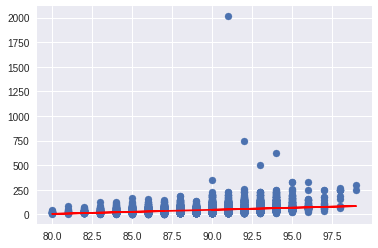

In [0]:
x = data.loc[:, ['points']]

y = data.loc[:, ['price']]

reg = LinearRegression().fit(x, y)
print(reg.score(x,y))

predict = reg.predict(x)

plt.scatter(x, y)  
plt.plot(x,predict,color = 'red')
plt.show()


0.0012341733580443215


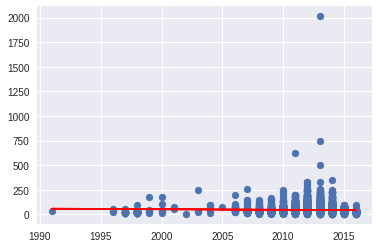

In [0]:
x = data.loc[:, ['vintage']]
y = data.loc[:, ['price']]

reg = LinearRegression().fit(x, y)
print(reg.score(x,y))

predict = reg.predict(x)

plt.scatter(x, y)  
plt.plot(x,predict,color = 'red')
plt.show()

0.019237457788118473


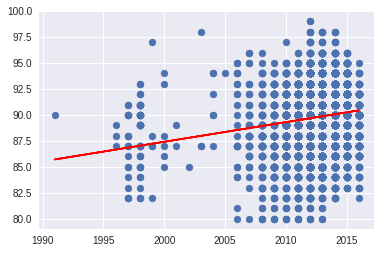

In [0]:
x = data.loc[:, ['vintage']]
y = data.loc[:, ['points']]

reg = LinearRegression().fit(x, y)
print(reg.score(x,y))

predict = reg.predict(x)

plt.scatter(x, y)  
plt.plot(x,predict,color = 'red')
plt.show()

0.1402716986372401


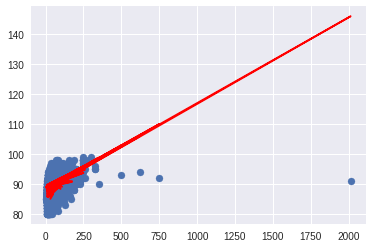

In [0]:
x = data.loc[:, ['vintage', 'price']]
y = data.loc[:, ['points']]

reg = LinearRegression().fit(x, y)
print(reg.score(x,y))

predict = reg.predict(x)

plt.scatter(x.iloc[:,1], y)  
plt.plot(x.iloc[:,1],predict,color = 'red')
plt.show()


## Analysis
Here, we can see that the features that we have in the base wine dataset do not have any high correlation with the rating or the price of the wine. We can see that a combination of the price and the vintage of the wine has the highest linear correlation at 14%, but the other features by themselves have less than a 10% correlation with either the rating of the price of the wine. This means that there are potentially other latent variables that affect the rating of the wines that are not in our current dataset. 

In [0]:
url = 'https://raw.githubusercontent.com/jems2019/CMPE257/master/data/'
data_set = 'wine_fire_weather_data.csv'
data = pd.read_csv(url+data_set)

data.dropna(inplace = True)
print(data.shape)
data.head()

(9268, 35)


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,...,norm_price,norm_points,norm_total_fires,norm_sum_fire_size,norm_total_fires_current,norm_sum_fire_size_current,mean_temp,mean_rain,norm_temp,norm_rain
0,0,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,...,0.006955,0.070707,0.000000,0.000000,0.450893,0.006877,59.757174,18.040338,0.219366,0.137560
1,1,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,Matt Kettmann,...,0.008445,0.070707,0.008929,0.000310,0.428571,0.002502,57.042925,23.084964,0.176770,0.192200
2,2,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,87,69.0,California,Sonoma Coast,Sonoma,Virginie Boone,...,0.031793,0.070707,0.000000,0.000000,0.450893,0.006877,59.757174,18.040338,0.219366,0.137560
3,3,US,"Syrupy and dense, this wine is jammy in plum a...",Estate,86,100.0,California,Napa Valley,Napa,Virginie Boone,...,0.047193,0.060606,0.272321,0.005246,0.551339,0.005689,61.338887,5.535779,0.244188,0.002119
4,4,US,There are intriguing touches to the nose of th...,Golden Horn,86,26.0,California,Santa Ynez Valley,Central Coast,Matt Kettmann,...,0.010432,0.060606,0.183036,0.002815,0.243304,0.010616,60.220294,12.206211,0.226633,0.074369


0.01030093787112396


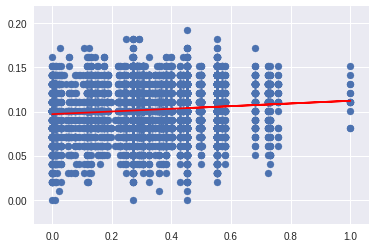

In [0]:
x = data.loc[:, ['norm_total_fires']]
y = data.loc[:, ['norm_points']]

reg = LinearRegression().fit(x, y)
print(reg.score(x,y))

predict = reg.predict(x)

plt.scatter(x, y)
plt.plot(x,predict,color = 'red')
plt.show()

0.000539192308368186


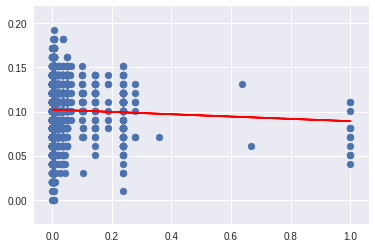

In [0]:
x = data.loc[:, ['norm_sum_fire_size']]
y = data.loc[:, ['norm_points']]

reg = LinearRegression().fit(x, y)
print(reg.score(x,y))

predict = reg.predict(x)

plt.scatter(x, y)
plt.plot(x,predict,color = 'red')
plt.show()

0.006024996123422666


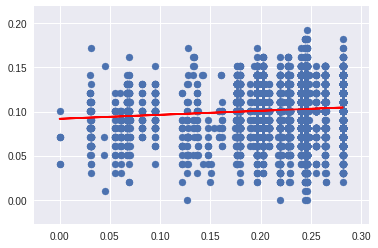

In [0]:
x = data.loc[:, ['norm_temp']]
y = data.loc[:, ['norm_points']]

reg = LinearRegression().fit(x, y)
print(reg.score(x,y))

predict = reg.predict(x)

plt.scatter(x, y)
plt.plot(x,predict,color = 'red')
plt.show()

0.00901565666260129


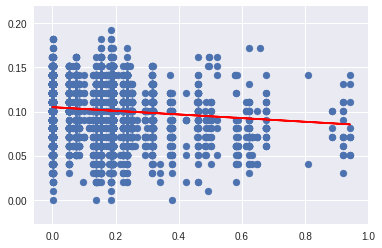

In [0]:
x = data.loc[:, ['norm_rain']]
y = data.loc[:, ['norm_points']]

reg = LinearRegression().fit(x, y)
print(reg.score(x,y))

predict = reg.predict(x)

plt.scatter(x, y)
plt.plot(x,predict,color = 'red')
plt.show()

## Analysis - Latent Manifolds

Here, we merged two other datasets, with [this notebook](https://https://github.com/jems2019/CMPE257/blob/master/Data%20Cleaning/Lat_Lng_Data_Cleaning.ipynb) to merge the wildfire dataset, then [this notebook](https://https://github.com/jems2019/CMPE257/blob/master/Data%20Cleaning/temperature%20and%20rain%20data%20merging.ipynb) to merge the temperature and precipitation datasets. We can see that the latent variables that we chose do not have any linear correlation with the ratings of the wine. This might be caused from the fact that there are so many different wines compared to the scale of the ratings. The Wine Enthusiast ratings has a range of 80 - 100, compared to our 10k different wines from Californa. Intuitutvely these factors should have an effect on the ratings of the wine, since temperature and rainfall directly affect how the grapes grow before they are turned into wine, and close fires to the vineyards might affect the grapes by increasing the amount of carbon emissions near the grapes, possibly reducing their potential to make better wine. 

### Linear Regression with our final dataset

In [0]:
url = 'https://raw.githubusercontent.com/jems2019/CMPE257/master/data/'
data_set = 'wine_fire_soup.csv'

data = pd.read_csv(url+data_set)
print(data.shape)
data.head()

(3278, 41)


,Unnamed: 0,Unnamed: 0.1,country,description,designation,points,price,province,region_1,region_2,...,norm_sum_fire_size_current,mean_temp,mean_rain,norm_temp,norm_rain,ratings,reviews,norm_ratings,norm_reviews,review_words
0,1,1,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,...,0.002502,57.042925,23.084964,0.176770,0.192200,4.0,117.0,0.4,0.060385,44
1,4,4,US,There are intriguing touches to the nose of th...,Golden Horn,86,26.0,California,Santa Ynez Valley,Central Coast,...,0.010616,60.220294,12.206211,0.226633,0.074369,4.0,262.0,0.4,0.135867,33
2,10,10,US,"This blend of Sangiovese, Malbec, Cabernet Sau...",Siena,88,23.0,California,Sonoma County,Sonoma,...,0.002549,63.720922,19.575900,0.281570,0.154192,3.5,257.0,0.3,0.133264,36
3,17,17,US,"Thick and brooding, this dark, sweetly tannic ...",K Block,91,85.0,California,Spring Mountain District,Napa,...,0.003793,61.338887,5.535779,0.244188,0.002119,5.0,3.0,0.6,0.001041,36
4,18,18,US,"Cooked cranberry is spiced with anise, pepperc...",Guidotti Vineyard,91,64.0,California,Santa Lucia Highlands,Central Coast,...,0.004112,58.685722,5.340118,0.202551,0.000000,4.0,18.0,0.4,0.008850,42


0.2642029937702455


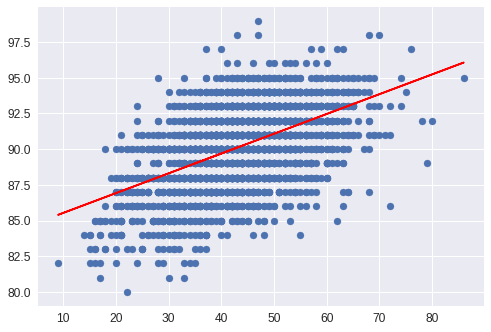


precision
0.15240207245290557
recall
0.15893837705918243
f1 score
0.1393608441064526




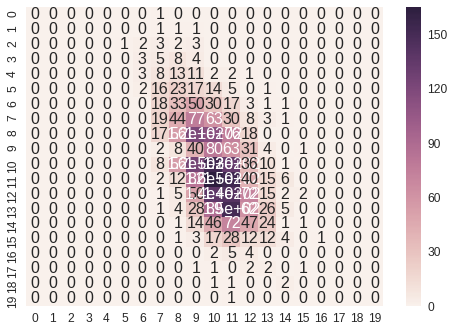

In [0]:
x = data.loc[:, ['review_words']]
y = data.loc[:, ['points']]

reg = LinearRegression().fit(x, y)
print(reg.score(x,y))

predict = reg.predict(x)

plt.scatter(x, y)  
plt.plot(x,predict,color = 'red')
plt.show()

model_stats(y, np.round(predict))

# Logistic Regression

In [0]:
url = 'https://raw.githubusercontent.com/jems2019/CMPE257/master/data/'
data_set = 'wine_fire_weather_data.csv'
data = pd.read_csv(url+data_set)

data.dropna(inplace = True)
print(data.shape)
data.head()

(9268, 35)


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,...,norm_price,norm_points,norm_total_fires,norm_sum_fire_size,norm_total_fires_current,norm_sum_fire_size_current,mean_temp,mean_rain,norm_temp,norm_rain
0,0,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,...,0.006955,0.070707,0.000000,0.000000,0.450893,0.006877,59.757174,18.040338,0.219366,0.137560
1,1,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,Matt Kettmann,...,0.008445,0.070707,0.008929,0.000310,0.428571,0.002502,57.042925,23.084964,0.176770,0.192200
2,2,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,87,69.0,California,Sonoma Coast,Sonoma,Virginie Boone,...,0.031793,0.070707,0.000000,0.000000,0.450893,0.006877,59.757174,18.040338,0.219366,0.137560
3,3,US,"Syrupy and dense, this wine is jammy in plum a...",Estate,86,100.0,California,Napa Valley,Napa,Virginie Boone,...,0.047193,0.060606,0.272321,0.005246,0.551339,0.005689,61.338887,5.535779,0.244188,0.002119
4,4,US,There are intriguing touches to the nose of th...,Golden Horn,86,26.0,California,Santa Ynez Valley,Central Coast,Matt Kettmann,...,0.010432,0.060606,0.183036,0.002815,0.243304,0.010616,60.220294,12.206211,0.226633,0.074369


0.05362537764350453


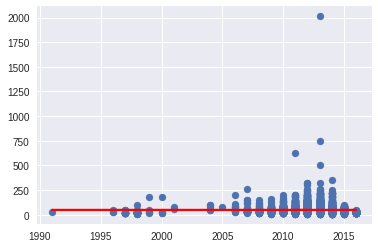

In [0]:
x = data.loc[:, ['vintage']]
y = data.loc[:, ['price']]

reg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(x, y)
print(reg.score(x,y))

predict = reg.predict(x)

plt.scatter(x, y)  

plt.plot(x,predict,color = 'red')
plt.show()

0.1667026327147173


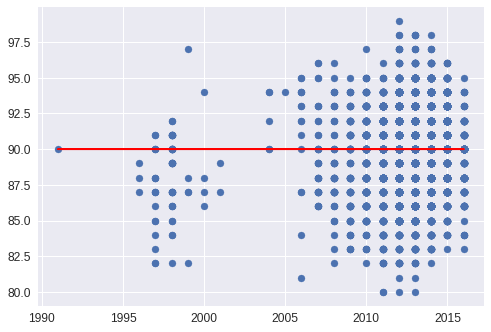


precision
0.027789767754017935
recall
0.1667026327147173
f1 score
0.04763813327369615


[90 90 90 ... 90 90 90]


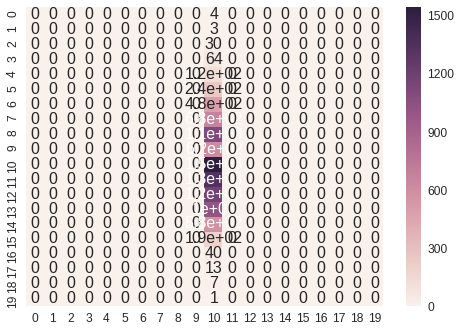

In [0]:
x = data.loc[:, ['vintage']]
y = data.loc[:, ['points']]

reg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(x, y)
print(reg.score(x,y))

predict = reg.predict(x)

plt.scatter(x, y)  

plt.plot(x,predict,color = 'red')
plt.show()

model_stats(y, predict)

print(predict)

0.1667026327147173


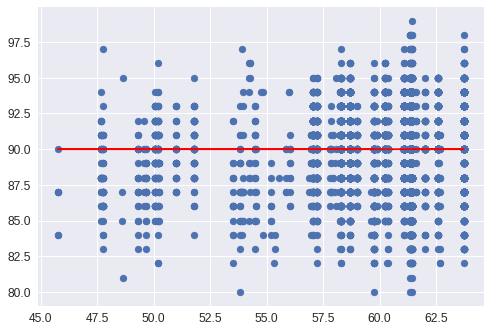


precision
0.027789767754017935
recall
0.1667026327147173
f1 score
0.04763813327369615




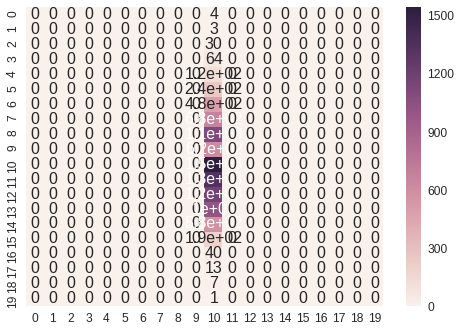

In [0]:
x = data.loc[:, ['mean_temp']]
y = data.loc[:, ['points']]

reg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(x, y)
print(reg.score(x,y))

predict = reg.predict(x)

plt.scatter(x, y)  
plt.plot(x,predict,color = 'red')
plt.show()

model_stats(y, predict)

0.16756581786793268


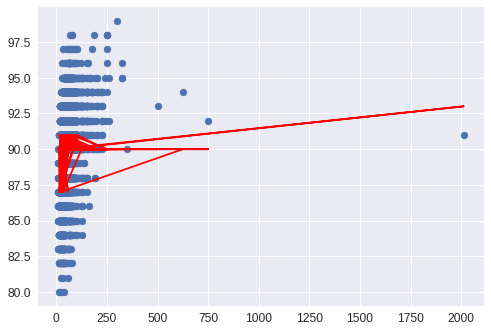


precision
0.06527656731654831
recall
0.16756581786793268
f1 score
0.05371478916362753




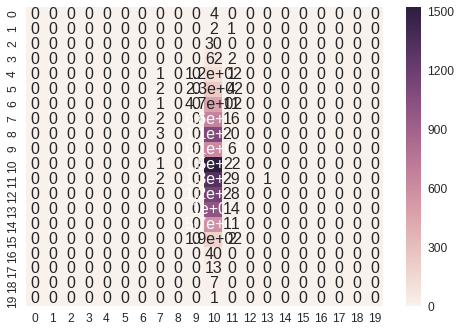

In [0]:
x = data.loc[:, ['vintage', 'price','total_fires','sum_fire_size', 'variety_numerical']]
y = data.loc[:, ['points']]

reg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(x, y)
print(reg.score(x,y))

predict = reg.predict(x)

plt.scatter(x.iloc[:,1], y)  

plt.plot(x.iloc[:,1],predict,color = 'red')
plt.show()

model_stats(y, predict)

Here, we convert the points into a binary value, 1 being good wines with a rating over 90, and 0 being bad wines with a score less than 90. We can then run logistic regression on the data with a binary output.

In [0]:

data['good_wine'] = 0
good_count= 0
for index, row in data.iterrows():
    if(row['points'] > 90):
        data.loc[index,'good_wine'] = 1
        good_count += 1
print(str(good_count) + ', ' + str(1-(good_count/data.shape[0])))
data.head()

4371, 0.5283772119119552


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,...,norm_points,norm_total_fires,norm_sum_fire_size,norm_total_fires_current,norm_sum_fire_size_current,mean_temp,mean_rain,norm_temp,norm_rain,good_wine
0,0,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,...,0.070707,0.000000,0.000000,0.450893,0.006877,59.757174,18.040338,0.219366,0.137560,0
1,1,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,Matt Kettmann,...,0.070707,0.008929,0.000310,0.428571,0.002502,57.042925,23.084964,0.176770,0.192200,0
2,2,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,87,69.0,California,Sonoma Coast,Sonoma,Virginie Boone,...,0.070707,0.000000,0.000000,0.450893,0.006877,59.757174,18.040338,0.219366,0.137560,0
3,3,US,"Syrupy and dense, this wine is jammy in plum a...",Estate,86,100.0,California,Napa Valley,Napa,Virginie Boone,...,0.060606,0.272321,0.005246,0.551339,0.005689,61.338887,5.535779,0.244188,0.002119,0
4,4,US,There are intriguing touches to the nose of th...,Golden Horn,86,26.0,California,Santa Ynez Valley,Central Coast,Matt Kettmann,...,0.060606,0.183036,0.002815,0.243304,0.010616,60.220294,12.206211,0.226633,0.074369,0


0.5936555891238671


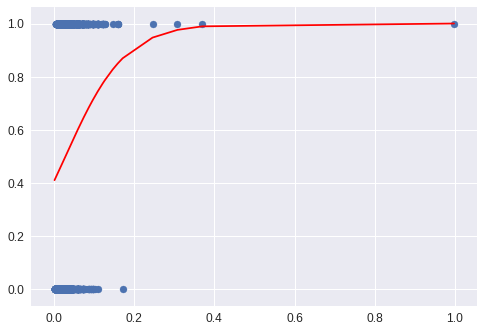


precision
0.6241619874543887
recall
0.5936555891238671
f1 score
0.5471994800709704




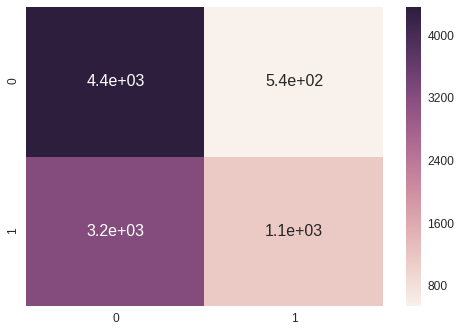

In [0]:
x = data.loc[:, ['norm_price']]
y = data.loc[:, ['good_wine']]

reg = LogisticRegression(random_state=0, solver='sag', multi_class='ovr').fit(x, y)
print(reg.score(x,y))

predict = reg.predict(x)

plt.scatter(x, y)  
x = x.sort_values(by = 'norm_price')
plt.plot(x,reg.predict_proba(x)[:,1],color = 'red')
plt.show()
model_stats(y, predict)

0.5360379801467414


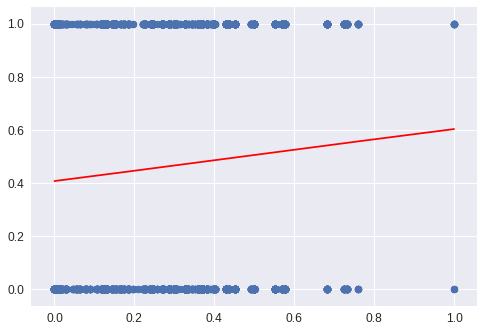


precision
0.5302094688968159
recall
0.5360379801467414
f1 score
0.49154784891132036




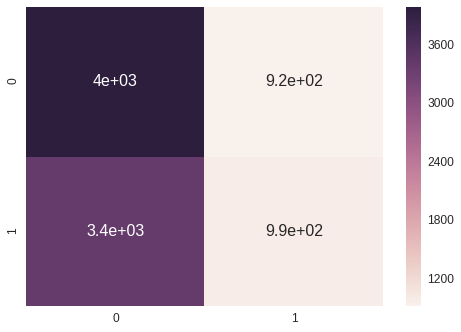

In [0]:
x = data.loc[:, ['norm_total_fires']]
y = data.loc[:, ['good_wine']]

reg = LogisticRegression(random_state=0, solver='saga', multi_class='ovr').fit(x, y)
print(reg.score(x,y))

predict = reg.predict(x)


plt.scatter(x, y)  
x = x.sort_values(by = 'norm_total_fires')
plt.plot(x,reg.predict_proba(x)[:,1],color = 'red')
plt.show()
model_stats(y, predict)

In [0]:
data['expensive_wine'] = 0
expensive= 0
for index, row in data.iterrows():
    if(row['price'] > 50):
        data.loc[index,'expensive_wine'] = 1
        expensive += 1
print(str(expensive) + ', ' + str(1 - (expensive/data.shape[0])))
data.head()

2877, 0.6895770392749245


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,...,norm_total_fires,norm_sum_fire_size,norm_total_fires_current,norm_sum_fire_size_current,mean_temp,mean_rain,norm_temp,norm_rain,good_wine,expensive_wine
0,0,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,...,0.000000,0.000000,0.450893,0.006877,59.757174,18.040338,0.219366,0.137560,0,0
1,1,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,Matt Kettmann,...,0.008929,0.000310,0.428571,0.002502,57.042925,23.084964,0.176770,0.192200,0,0
2,2,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,87,69.0,California,Sonoma Coast,Sonoma,Virginie Boone,...,0.000000,0.000000,0.450893,0.006877,59.757174,18.040338,0.219366,0.137560,0,1
3,3,US,"Syrupy and dense, this wine is jammy in plum a...",Estate,86,100.0,California,Napa Valley,Napa,Virginie Boone,...,0.272321,0.005246,0.551339,0.005689,61.338887,5.535779,0.244188,0.002119,0,1
4,4,US,There are intriguing touches to the nose of th...,Golden Horn,86,26.0,California,Santa Ynez Valley,Central Coast,Matt Kettmann,...,0.183036,0.002815,0.243304,0.010616,60.220294,12.206211,0.226633,0.074369,0,0


0.6895770392749244


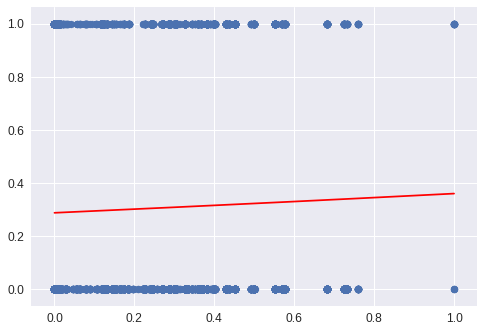


precision
0.47551649309517074
recall
0.6895770392749244
f1 score
0.5628822859705016




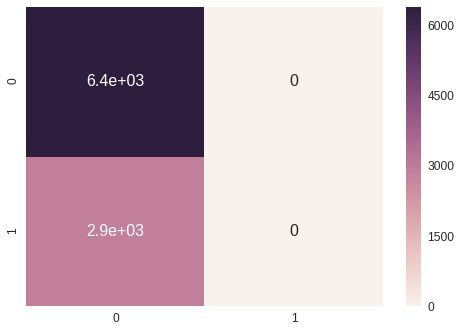

In [0]:
x = data.loc[:, ['norm_total_fires']]
y = data.loc[:, ['expensive_wine']]

reg = LogisticRegression(random_state=0, solver='saga', multi_class='ovr').fit(x, y)
print(reg.score(x,y))

predict = reg.predict(x)

plt.scatter(x, y)  
x = x.sort_values(by = 'norm_total_fires')
plt.plot(x,reg.predict_proba(x)[:,1],color = 'red')

plt.show()

model_stats(y, predict)

### Logistic Regression with our final dataset

In [0]:
url = 'https://raw.githubusercontent.com/jems2019/CMPE257/master/data/'
data_set = 'wine_fire_soup.csv'

data = pd.read_csv(url+data_set)
print(data.shape)
data.head()

(3278, 41)


,Unnamed: 0,Unnamed: 0.1,country,description,designation,points,price,province,region_1,region_2,...,norm_sum_fire_size_current,mean_temp,mean_rain,norm_temp,norm_rain,ratings,reviews,norm_ratings,norm_reviews,review_words
0,1,1,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,...,0.002502,57.042925,23.084964,0.176770,0.192200,4.0,117.0,0.4,0.060385,44
1,4,4,US,There are intriguing touches to the nose of th...,Golden Horn,86,26.0,California,Santa Ynez Valley,Central Coast,...,0.010616,60.220294,12.206211,0.226633,0.074369,4.0,262.0,0.4,0.135867,33
2,10,10,US,"This blend of Sangiovese, Malbec, Cabernet Sau...",Siena,88,23.0,California,Sonoma County,Sonoma,...,0.002549,63.720922,19.575900,0.281570,0.154192,3.5,257.0,0.3,0.133264,36
3,17,17,US,"Thick and brooding, this dark, sweetly tannic ...",K Block,91,85.0,California,Spring Mountain District,Napa,...,0.003793,61.338887,5.535779,0.244188,0.002119,5.0,3.0,0.6,0.001041,36
4,18,18,US,"Cooked cranberry is spiced with anise, pepperc...",Guidotti Vineyard,91,64.0,California,Santa Lucia Highlands,Central Coast,...,0.004112,58.685722,5.340118,0.202551,0.000000,4.0,18.0,0.4,0.008850,42


In [0]:

data['good_wine'] = 0
good_count= 0
for index, row in data.iterrows():
    if(row['points'] > 90):
        data.loc[index,'good_wine'] = 1
        good_count += 1
print(str(good_count) + ', ' + str(1-(good_count/data.shape[0])))
data.head()

1574, 0.5198291641244661


,Unnamed: 0,Unnamed: 0.1,country,description,designation,points,price,province,region_1,region_2,...,mean_temp,mean_rain,norm_temp,norm_rain,ratings,reviews,norm_ratings,norm_reviews,review_words,good_wine
0,1,1,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,...,57.042925,23.084964,0.176770,0.192200,4.0,117.0,0.4,0.060385,44,0
1,4,4,US,There are intriguing touches to the nose of th...,Golden Horn,86,26.0,California,Santa Ynez Valley,Central Coast,...,60.220294,12.206211,0.226633,0.074369,4.0,262.0,0.4,0.135867,33,0
2,10,10,US,"This blend of Sangiovese, Malbec, Cabernet Sau...",Siena,88,23.0,California,Sonoma County,Sonoma,...,63.720922,19.575900,0.281570,0.154192,3.5,257.0,0.3,0.133264,36,0
3,17,17,US,"Thick and brooding, this dark, sweetly tannic ...",K Block,91,85.0,California,Spring Mountain District,Napa,...,61.338887,5.535779,0.244188,0.002119,5.0,3.0,0.6,0.001041,36,1
4,18,18,US,"Cooked cranberry is spiced with anise, pepperc...",Guidotti Vineyard,91,64.0,California,Santa Lucia Highlands,Central Coast,...,58.685722,5.340118,0.202551,0.000000,4.0,18.0,0.4,0.008850,42,1


0.6668700427089689


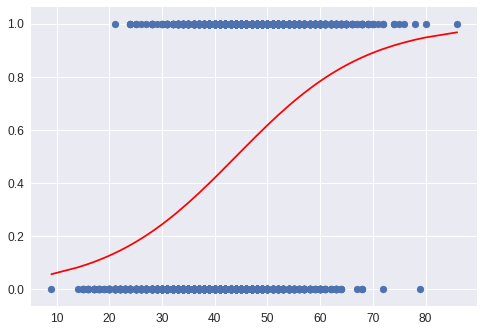


precision
0.6666522363439804
recall
0.6668700427089689
f1 score
0.6662339314292651




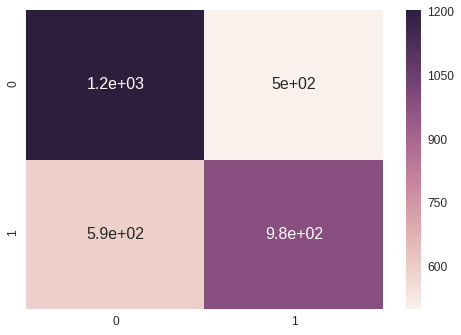

In [0]:
x = data.loc[:, ['review_words']]
y = data.loc[:, ['good_wine']]

reg = LogisticRegression(random_state=0, solver='sag', multi_class='ovr').fit(x, y)
print(reg.score(x,y))

predict = reg.predict(x)

plt.scatter(x, y)  
x = x.sort_values(by = 'review_words')
plt.plot(x,reg.predict_proba(x)[:,1],color = 'red')
plt.show()
model_stats(y, predict)

# Naive Bayes

Here, we want to try to predict the rating of the wine using naive bayes. We are using the price, variety, vintage and the fires that happened around the vineyard that the wines came from. By predicting the wine points, growers can decide what variety of grapes to plant in the future, as well as change the prices of exisiting wines to see try to get higher wine entusiast scores. 

In [0]:
# Load the cleaned data into dataframe

""" 
    Information of cleaned dataset:
    
    - Province and Variety of wine is transfomed from a categorical attribute to numerical attribute
    - Vintage of wine is extracted from the title of each wine
    - Rows were removed if there were null values present within each of the three attributes (Province, Variety, Vintage)
    
"""
warnings.simplefilter('ignore')

url = 'https://raw.githubusercontent.com/jems2019/CMPE257/master/data/'
data_set = 'final_wine_and_fire_data.csv'

data = pd.read_csv(url+data_set)
print(data.shape)
data.head()

(9757, 31)


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,...,total_fires_current,sum_fire_size_current,norm_vintage,norm_variety_numerical,norm_price,norm_points,norm_total_fires,norm_sum_fire_size,norm_total_fires_current,norm_sum_fire_size_current
0,0,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,...,202,1756.38,0.009921,0.113960,0.006955,0.070707,0.000000,0.000000,0.450893,0.006877
1,1,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,Matt Kettmann,...,192,639.14,0.009921,0.464387,0.008445,0.070707,0.008929,0.000310,0.428571,0.002502
2,2,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,87,69.0,California,Sonoma Coast,Sonoma,Virginie Boone,...,202,1756.38,0.009921,0.626781,0.031793,0.070707,0.000000,0.000000,0.450893,0.006877
3,3,US,"Syrupy and dense, this wine is jammy in plum a...",Estate,86,100.0,California,Napa Valley,Napa,Virginie Boone,...,247,1453.08,0.010913,0.113960,0.047193,0.060606,0.272321,0.005246,0.551339,0.005689
4,4,US,There are intriguing touches to the nose of th...,Golden Horn,86,26.0,California,Santa Ynez Valley,Central Coast,Matt Kettmann,...,109,2711.55,0.011905,0.732194,0.010432,0.060606,0.183036,0.002815,0.243304,0.010616


Here we run gaussian naive bayes on our data. Gaussian naive bayes assumes that the likelihood of the features have a gaussian distribution. We can see that trying to run naive bayes to predict the raw point value has a very low accuracy because there are too many classes to predict on since the price ranges from 80-100. The best accuracy from predicting on points is only 16%, and from the confusion matrix we can see that the algorithm just predicts the same score for all test samples. 


precision
0.12352248657494569
recall
0.16086065573770492
f1 score
0.11285609243345186


5 fold cross validation accuracies
[0.1578141  0.16683726 0.1567623  0.17188302 0.16820988]


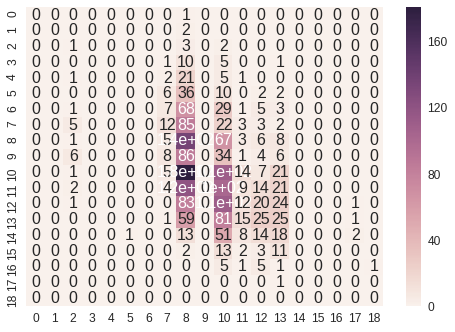

In [0]:
x = data.loc[:, ['norm_vintage', 'norm_price', 'norm_variety_numerical']]
y = data.loc[:, 'points']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.20, random_state=0)

n_bayes = GaussianNB()
n_bayes.fit(x_train,y_train)

predict = n_bayes.predict(x_test)
model_stats(y_test, predict)

print('5 fold cross validation accuracies')
print(cross_val_score(n_bayes, x ,y ,cv = 5))


precision
0.05731917424347291
recall
0.14293032786885246
f1 score
0.06034627442441892


5 fold cross validation accuracies
[0.1639428  0.13408393 0.12192623 0.13442791 0.14660494]


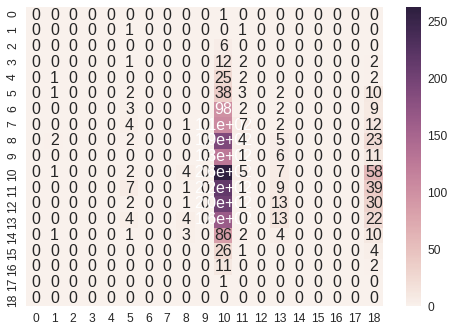

In [0]:
x = data.loc[:, ['norm_total_fires', 'norm_sum_fire_size']]
y = data.loc[:, 'points']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.20, random_state=0)

n_bayes = GaussianNB()
n_bayes.fit(x_train,y_train)

predict = n_bayes.predict(x_test)

model_stats(y_test, predict)
print('5 fold cross validation accuracies')
print(cross_val_score(n_bayes, x ,y , cv = 5))


precision
0.029601095636742413
recall
0.1720496894409938
f1 score
0.05051167352957635


5 fold cross validation accuracies
[0.16292135 0.16325486 0.16342213 0.16367368 0.16409465]


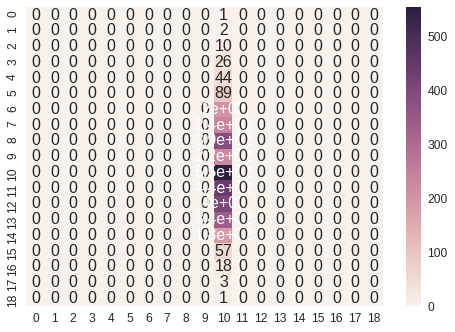

In [0]:
x = data.loc[:, 'points']
x = np.array(x, dtype=pd.Series)
x = x.reshape(-1, 1)
y = data.loc[:, 'points']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.33, random_state=0)

n_bayes = MultinomialNB()
n_bayes.fit(x_train,y_train)

predict = n_bayes.predict(x_test)
model_stats(y_test, predict)

print('5 fold cross validation accuracies')
print(cross_val_score(n_bayes, x ,y ,cv = 5))

To try to improve our accuracy, we binned the points into 3 groups, good, medium and mediocre wines. After running naive bayes on the binned data, we can see that the accuracy increases to ~40%. From the confusion matrices, we can see that the algorithm seems to ignore one of the bins when predicting, which could be due to the fact that our data is not very correlated. 

In [0]:
points = data.loc[:,'points']
points = np.array(points, dtype=pd.Series)
points = points.reshape(-1, 1)
cluster = KMeans(n_clusters = 3, random_state = 0).fit(points)
point_bins = cluster.labels_

data['point_bin'] = point_bins


precision
0.38635493329876924
recall
0.4088114754098361
f1 score
0.3605432143414068


5 fold cross validation accuracies
[0.41137295 0.4272541  0.40829918 0.41209636 0.41230769]


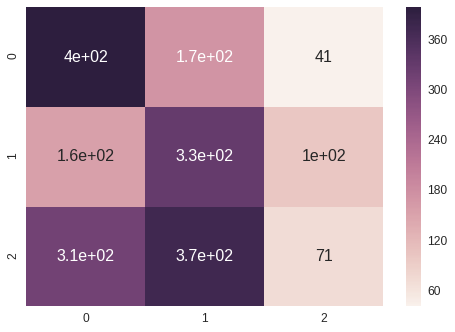

In [0]:
x = data.loc[:, ['norm_price', 'norm_total_fires', 'norm_sum_fire_size']]
y = data.loc[:, 'point_bin']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.20, random_state=0)

n_bayes = GaussianNB()
n_bayes.fit(x_train,y_train)

predict = n_bayes.predict(x_test)

model_stats(y_test, predict)
print('5 fold cross validation accuracies')
print(cross_val_score(n_bayes, x ,y , cv = 5))


precision
0.40801737513232206
recall
0.413422131147541
f1 score
0.32606329432398085


5 fold cross validation accuracies
[0.42520492 0.43852459 0.40932377 0.42029728 0.40615385]


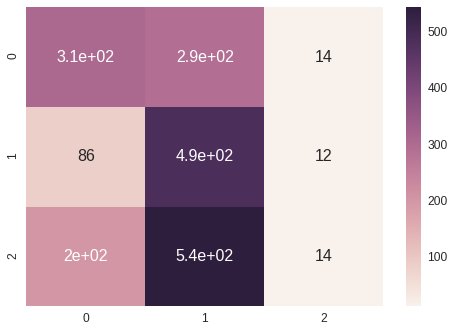

In [0]:
x = data.loc[:, ['norm_price', 'norm_total_fires_current', 'norm_sum_fire_size_current']]
y = data.loc[:, 'point_bin']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.20, random_state=0)

n_bayes = GaussianNB()
n_bayes.fit(x_train,y_train)

predict = n_bayes.predict(x_test)

model_stats(y_test, predict)
print('5 fold cross validation accuracies')
print(cross_val_score(n_bayes, x ,y , cv = 5))


precision
0.37508407133067906
recall
0.39139344262295084
f1 score
0.3276335371800478


5 fold cross validation accuracies
[0.39139344 0.40778689 0.40778689 0.4249103  0.42615385]


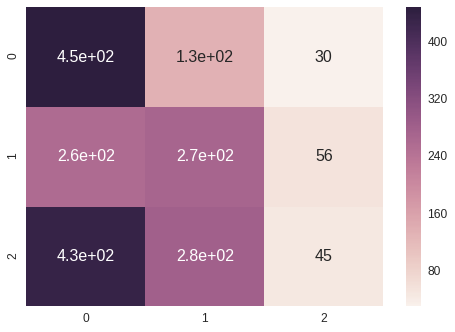

In [0]:
x = data.loc[:, ['norm_price', 'lat', 'lon']]
y = data.loc[:, 'point_bin']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.20, random_state=0)

n_bayes = GaussianNB()
n_bayes.fit(x_train,y_train)

predict = n_bayes.predict(x_test)

model_stats(y_test, predict)
print('5 fold cross validation accuracies')
print(cross_val_score(n_bayes, x ,y , cv = 5))

### Naive Bayes with our final dataset

In [0]:
url = 'https://raw.githubusercontent.com/jems2019/CMPE257/master/data/'
data_set = 'wine_fire_soup.csv'

data = pd.read_csv(url+data_set)
print(data.shape)
data.head()

(3278, 41)


,Unnamed: 0,Unnamed: 0.1,country,description,designation,points,price,province,region_1,region_2,...,norm_sum_fire_size_current,mean_temp,mean_rain,norm_temp,norm_rain,ratings,reviews,norm_ratings,norm_reviews,review_words
0,1,1,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,...,0.002502,57.042925,23.084964,0.176770,0.192200,4.0,117.0,0.4,0.060385,44
1,4,4,US,There are intriguing touches to the nose of th...,Golden Horn,86,26.0,California,Santa Ynez Valley,Central Coast,...,0.010616,60.220294,12.206211,0.226633,0.074369,4.0,262.0,0.4,0.135867,33
2,10,10,US,"This blend of Sangiovese, Malbec, Cabernet Sau...",Siena,88,23.0,California,Sonoma County,Sonoma,...,0.002549,63.720922,19.575900,0.281570,0.154192,3.5,257.0,0.3,0.133264,36
3,17,17,US,"Thick and brooding, this dark, sweetly tannic ...",K Block,91,85.0,California,Spring Mountain District,Napa,...,0.003793,61.338887,5.535779,0.244188,0.002119,5.0,3.0,0.6,0.001041,36
4,18,18,US,"Cooked cranberry is spiced with anise, pepperc...",Guidotti Vineyard,91,64.0,California,Santa Lucia Highlands,Central Coast,...,0.004112,58.685722,5.340118,0.202551,0.000000,4.0,18.0,0.4,0.008850,42


In [0]:
points = data.loc[:,'points']
points = np.array(points, dtype=pd.Series)
points = points.reshape(-1, 1)
cluster = KMeans(n_clusters = 3, random_state = 0).fit(points)
point_bins = cluster.labels_

data['point_bin'] = point_bins


precision
0.46677293876248405
recall
0.4740853658536585
f1 score
0.3937161323563009


5 fold cross validation accuracies
[0.48249619 0.47865854 0.47865854 0.47633588 0.50152905]


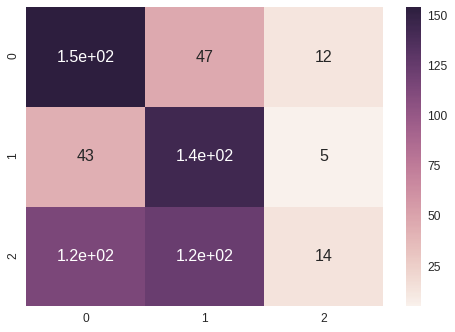

In [0]:
x = data.loc[:, ['norm_price', 'review_words', 'norm_temp', 'norm_rain', 'norm_ratings', 'norm_reviews']]
y = data.loc[:, 'point_bin']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.20, random_state=0)

n_bayes = GaussianNB()
n_bayes.fit(x_train,y_train)

predict = n_bayes.predict(x_test)

model_stats(y_test, predict)
print('5 fold cross validation accuracies')
print(cross_val_score(n_bayes, x ,y , cv = 5))

We performed Naive Bayes again on our final dataset as shown above. Here we are prediticting the wine bin rating(good, medium, mediocre) using the price, the review word count, temperature, rain,  ratings. We saw that the accuracy went up to ~47% meaning the newly added feature like review word count has a impact on the wine bin rating. 

#Beautiful Soup

In [0]:
# gets all the unique wineries and region from the dataset
unique_wineries = data.drop_duplicates(subset=['region_1', 'winery'], keep='first', inplace=False)
#unique_wineries.shape


unique_wineries.iloc[0,unique_wineries.columns.get_loc("winery")]

'Bianchi'

In [0]:
url = 'https://raw.githubusercontent.com/jems2019/CMPE257/master/Beautiful_Soup/unique_wineries.csv'
unique_wineries = pd.read_csv(url)
unique_wineries.head()

,Unnamed: 0,Unnamed: 0.1,country,description,designation,points,price,province,region_1,region_2,...,norm_price,norm_points,norm_total_fires,norm_sum_fire_size,norm_total_fires_current,norm_sum_fire_size_current,mean_temp,mean_rain,norm_temp,norm_rain
0,0,0,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,...,0.006955,0.070707,0.000000,0.000000,0.450893,0.006877,59.757174,18.040338,0.219366,0.137560
1,1,1,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,...,0.008445,0.070707,0.008929,0.000310,0.428571,0.002502,57.042925,23.084964,0.176770,0.192200
2,2,2,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,87,69.0,California,Sonoma Coast,Sonoma,...,0.031793,0.070707,0.000000,0.000000,0.450893,0.006877,59.757174,18.040338,0.219366,0.137560
3,3,3,US,"Syrupy and dense, this wine is jammy in plum a...",Estate,86,100.0,California,Napa Valley,Napa,...,0.047193,0.060606,0.272321,0.005246,0.551339,0.005689,61.338887,5.535779,0.244188,0.002119
4,4,4,US,There are intriguing touches to the nose of th...,Golden Horn,86,26.0,California,Santa Ynez Valley,Central Coast,...,0.010432,0.060606,0.183036,0.002815,0.243304,0.010616,60.220294,12.206211,0.226633,0.074369


In [0]:
headers = ({'User-Agent':
            #'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})
             'Chrome/41.0.2228.0 Safari/537.36'})
  
  

yelp_url = 'https://www.yelp.com/search?find_desc='

# starting index from unique wineries dataset
start = 0
end = unique_wineries.shape[0]
# for demo in master notebook
end = 5


# setting up the lists that will form the dataframe with all the winery ratings
winery_list = []
region_list = []
ratings_list = []
num_reviews = []
dollar_list = []

  
start_time = time.time()

# number of wineries completed
finished = 0

while (start < end):
    winery = unique_wineries.iloc[start,unique_wineries.columns.get_loc("winery")]
    location = unique_wineries.iloc[start,unique_wineries.columns.get_loc("region_1")]
    url = yelp_url + winery + '&find_loc=' + location + ', CA'
    response = get(url, headers=headers)

    print(url)
    print(response)
    # parse the html using beautiful soup and store in variable `soup`
    soup = BeautifulSoup(response.text, 'html.parser')
    
    
    if ('robot' in soup.text):
        print('CAPTCHA')
    
    winery_containers = soup.find_all('div', class_="lemon--div__373c0__1mboc searchResult__373c0__1yggB border-color--default__373c0__2oFDT")
    i = 0

    if winery_containers != []:  
        bool = False
        for container in winery_containers:
            
            # if the winery has already been added to the list
            if (bool == True):
              bool = False
              break
              
          # get the winery name from Yelp
            soup_name = winery_containers[i].find_all('h3')[0].text

          # if the soup name contains the winery name 
          # and the soup name has winery or vineyard 
          
            if (str(winery) in str(soup_name)): #or (str(winery) in str(soup_name) and ('winery' in soup_name.lower() or 'vineyard' in soup_name.lower() or 'cellars' in soup_name.lower())):
                bool = True
                print(winery + ' recorded.')
                winery_list.append(winery)
                region_list.append(location)
                
                 # get the winery rating from Yelp
                soup_rating = winery_containers[i].find('span', attrs={'class': 'lemon--span__373c0__3997G display--inline__373c0__1DbOG border-color--default__373c0__2oFDT'})
                if (soup_rating):
                    try:
                      rating = soup_rating.div.get("aria-label").replace(' star rating', '')
                      ratings_list.append(rating)
                    except:
                      ratings_list.append(float('NaN'))
                else:
                    ratings_list.append(float('NaN'))
        
                # get the number of Yelp reviews for the winery
                soup_review = winery_containers[i].find('span', attrs={'class': 'lemon--span__373c0__3997G text__373c0__2pB8f reviewCount__373c0__2r4xT text-color--mid__373c0__3G312 text-align--left__373c0__2pnx_'})
                if (soup_review):
                    try:
                      match = str(re.search(r' review\w*', soup_review.text).group(0))
                      soup_review_val = soup_review.text.replace(match, '')
                      num_reviews.append(soup_review_val)
                    except:
                      num_reviews.append(float('NaN'))
                else:
                    num_reviews.append(float('NaN'))
        
        
                # get the number of Yelp dollar signs for the winery
                soup_dollars = winery_containers[i].find('span', attrs={'class': 'lemon--span__373c0__3997G text__373c0__2pB8f priceRange__373c0__2DY87 text-color--normal__373c0__K_MKN text-align--left__373c0__2pnx_ text-bullet--after__373c0__1ZHaA'})
                if (soup_dollars):
                    try: 
                      dollar_list.append(soup_dollars.text)
                    except:
                      dollar_list.append(float('NaN'))
                else:
                    dollar_list.append(float('NaN'))
    
      
    
            i += 1

   
    start+=1 
    finished += 1 
    
    print('finished' , finished, '/', unique_wineries.shape[0], ' --- time elapsed:', time.time() - start_time)
    
    sleep(randint(1,2))
    
    # write data into data.csv after every 25 calls
    if (finished % 25 == 0):
        cols = ['Winery', 'Region', 'Ratings', 'Number of Reviews', 'Yelp Dollar Signs']
        res = pd.DataFrame({'Winery': winery_list, 'Region': region_list, 'Ratings': ratings_list, 'Number of Reviews': num_reviews, 'Yelp Dollar Signs': dollar_list})[cols]
        res.to_csv('data.csv')
        !cp data.csv drive/My\ Drive/ # copy to drive if using Colab




https://www.yelp.com/search?find_desc=Kirkland Signature&find_loc=Napa Valley, CA
<Response [200]>
finished 1 / 2629  --- time elapsed: 1.907013177871704
https://www.yelp.com/search?find_desc=Bianchi&find_loc=Paso Robles, CA
<Response [200]>
Bianchi recorded.
finished 2 / 2629  --- time elapsed: 6.009430885314941
https://www.yelp.com/search?find_desc=Castello di Amorosa&find_loc=Sonoma Coast, CA
<Response [200]>
Castello di Amorosa recorded.
finished 3 / 2629  --- time elapsed: 8.595240116119385
https://www.yelp.com/search?find_desc=Okapi&find_loc=Napa Valley, CA
<Response [200]>
finished 4 / 2629  --- time elapsed: 12.48000431060791
https://www.yelp.com/search?find_desc=Sevtap&find_loc=Santa Ynez Valley, CA
<Response [200]>
Sevtap recorded.
finished 5 / 2629  --- time elapsed: 16.50561261177063


#Decision Tree

In [0]:
url = 'https://raw.githubusercontent.com/jems2019/CMPE257/master/data/'
data_set = 'wine_fire_soup.csv'
data = pd.read_csv(url+data_set)

In [0]:
# this is to look and see how many unique winerys we have in the dataset.
len(pd.unique(data['winery']))

405

In [0]:
# getting the data that will be used for creating the decision tree. This is also creating the trainind and testing set.   
x = data[['norm_variety_numerical', 'norm_price', 'vintage', 'norm_ratings', 'norm_reviews']]
y = data[['points']]

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.10, random_state=0)

In [0]:
# Setting up the decision tree classifier. Using the training and the testing data we created.
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)
predict = clf.predict(x_test)

In [0]:
data.head()

,Unnamed: 0,Unnamed: 0.1,country,description,designation,points,price,province,region_1,region_2,...,norm_sum_fire_size_current,mean_temp,mean_rain,norm_temp,norm_rain,ratings,reviews,norm_ratings,norm_reviews,review_words
0,1,1,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,...,0.002502,57.042925,23.084964,0.176770,0.192200,4.0,117.0,0.4,0.060385,44
1,4,4,US,There are intriguing touches to the nose of th...,Golden Horn,86,26.0,California,Santa Ynez Valley,Central Coast,...,0.010616,60.220294,12.206211,0.226633,0.074369,4.0,262.0,0.4,0.135867,33
2,10,10,US,"This blend of Sangiovese, Malbec, Cabernet Sau...",Siena,88,23.0,California,Sonoma County,Sonoma,...,0.002549,63.720922,19.575900,0.281570,0.154192,3.5,257.0,0.3,0.133264,36
3,17,17,US,"Thick and brooding, this dark, sweetly tannic ...",K Block,91,85.0,California,Spring Mountain District,Napa,...,0.003793,61.338887,5.535779,0.244188,0.002119,5.0,3.0,0.6,0.001041,36
4,18,18,US,"Cooked cranberry is spiced with anise, pepperc...",Guidotti Vineyard,91,64.0,California,Santa Lucia Highlands,Central Coast,...,0.004112,58.685722,5.340118,0.202551,0.000000,4.0,18.0,0.4,0.008850,42


In [0]:
# this function is to calculate the accuracy of the decision tree.
accuracy_score(y_test, predict)

0.25609756097560976

Plotting the points and auto binning them. We realized that the points column 
in the data set is between a 80 and 100 and we decided to bin the points to 
make the data more useful for the classification engines. 

(array([  1.,   3.,   0.,  11.,   0.,  20.,   0.,  40.,   0.,  78.,   0.,
        153.,   0., 245.,   0., 402.,   0., 229., 522.,   0., 475.,   0.,
        426.,   0., 366.,   0., 206.,   0.,  78.,   0.,  11.,   0.,   7.,
          0.,   4.,   1.]),
 array([80.        , 80.52777778, 81.05555556, 81.58333333, 82.11111111,
        82.63888889, 83.16666667, 83.69444444, 84.22222222, 84.75      ,
        85.27777778, 85.80555556, 86.33333333, 86.86111111, 87.38888889,
        87.91666667, 88.44444444, 88.97222222, 89.5       , 90.02777778,
        90.55555556, 91.08333333, 91.61111111, 92.13888889, 92.66666667,
        93.19444444, 93.72222222, 94.25      , 94.77777778, 95.30555556,
        95.83333333, 96.36111111, 96.88888889, 97.41666667, 97.94444444,
        98.47222222, 99.        ]),
 <a list of 36 Patch objects>)

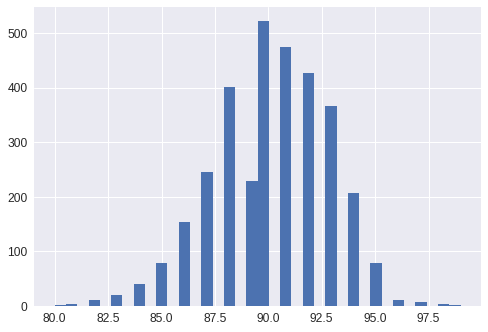

In [0]:
plt.hist(data['points'], bins='auto') 

Taking the binned points that was created for the histogram and adding them to 
corrected bin counts for the price to the dataset so we can use it in our analysis
We are using KMeans clustering to find the optimal bin counts for the points. 

In [0]:
points = data.loc[:,'points']
points = np.array(points, dtype=pd.Series)
points = points.reshape(-1, 1)
cluster = KMeans(n_clusters = 3, random_state = 0).fit(points)
point_bins = cluster.labels_

data['point_bin'] = point_bins

In [0]:
label_count(point_bins)
get_top_x_per_cluster(10,'points',data,point_bins,3)

{1: 953, 2: 1226, 0: 1099}

Top 10 points in each cluster

Cluster  0
(92, 426)
(93, 366)
(94, 206)
(95, 78)
(96, 11)
(97, 7)
(98, 4)
(99, 1)

Cluster  1
(88, 402)
(87, 245)
(86, 153)
(85, 78)
(84, 40)
(83, 20)
(82, 11)
(81, 3)
(80, 1)

Cluster  2
(90, 522)
(91, 475)
(89, 229)


Running the decision tree classifier with the new point_bin data this should
yield a better accuracy score for the DT.

In [0]:
x = data[['norm_variety_numerical', 'norm_price', 'vintage', 'norm_reviews']]
y = data[['point_bin']]

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.20, random_state=0)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)
predict = clf.predict(x_test)

accuracy_score(y_test, predict)

0.5487804878048781

Here we are adding data that we gathered from a wild fire dataset. We enriched our dataset
using the fire dataset and specifically added total fires and fire size. We then counted 
the number of fires in a given area that happened near one of the wineries in our dataset.
We are hoping that these new features will help improve the accuray of our model. 

In [0]:
x = data.loc[:, ['norm_variety_numerical', 'norm_price', 'norm_total_fires', 'norm_sum_fire_size', 'norm_ratings', 'norm_reviews']]
y = data.loc[:, ['point_bin']]

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.20, random_state=0)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)
predict = clf.predict(x_test)

accuracy_score(y_test, predict)

0.5198170731707317

Exploring the dataset to see if there are any better matches that will improve the overall
accuracy of the model.

In [0]:
x = data[['sum_fire_size', 'norm_ratings']]
y = data[['point_bin']]

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.20, random_state=0)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)
predict = clf.predict(x_test)

accuracy_score(y_test, predict)

0.4054878048780488

After exploring the data and running the model, we then needed to gather the important scores for the model to see how it is performing.
We are looking for the precision, f1 score, and the recall. We also ran the cross calidation score, this is another tool we used to determine if our model was working correctly. Once we have the scores we also generate a confusion matrix. 



precision
0.40703403140678435
recall
0.4054878048780488
f1 score
0.40069527770127283


cross validation using 5:
[0.41552511 0.42530488 0.44664634 0.40305344 0.39602446]


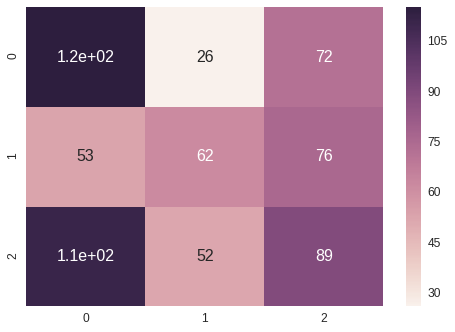

In [0]:
model_stats(y_test, predict)
print ('cross validation using 5:')
print(cross_val_score(clf, x ,y , cv = 5))

##Analysis- Decision Tree

We found that running the decision tree model helped us to understand our data better. We found that there are a few very impactful features that matter most with the data. Another important thing that we found is that we needed to bin our points column, by doing this we greatly improved our accuracy. However this did not improve the accuracy to a point that we were hoping. It pushed a little more then 50% accurate. We are hoping that by enriching our data with some more outside data as well as looking for the latent variables that have the greatest effect on the data we will be able to optimize our accuracy score. 

#Random Forest

Here we are trying to predict the rating of the wines by using the Random forest model. In this model we are going to pass all the features that we believe are important. Using the feature importance score as a metric to verify that what we believe is an important feature is in fact an important feature. We are hoping to improve the overall accuracy of our predictions with information that we gain from running this model. 

In [0]:
url = 'https://raw.githubusercontent.com/jems2019/CMPE257/master/data/'
data_set = 'wine_fire_soup.csv'
data = pd.read_csv(url+data_set)

In [0]:
data.describe()
data.dropna(inplace=True)
data.shape

(3278, 41)

In [0]:
names_col = [data.columns]
for i in range(len(names_col)):
    print (names_col[i])

Index(['Unnamed: 0', 'Unnamed: 0.1', 'country', 'description', 'designation',
       'points', 'price', 'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery', 'province_id',
       'variety_numerical', 'vintage', 'lat', 'lon', 'total_fires',
       'sum_fire_size', 'total_fires_current', 'sum_fire_size_current',
       'norm_vintage', 'norm_variety_numerical', 'norm_price', 'norm_points',
       'norm_total_fires', 'norm_sum_fire_size', 'norm_total_fires_current',
       'norm_sum_fire_size_current', 'mean_temp', 'mean_rain', 'norm_temp',
       'norm_rain', 'ratings', 'reviews', 'norm_ratings', 'norm_reviews',
       'review_words'],
      dtype='object')


Here we looking for more features that we can use in the training and the testing of the random forest model. We are creating a numerical feature for the twitter handle for the people who reviewd and rated the wines, as well as converting the wine name to a numerical value. We will then use these to see if they have any impact on predicting the price of the wine. 

In [0]:
len(data.taster_twitter_handle.unique().sum())
ref_dict = {}
for i, x in enumerate(data.taster_twitter_handle.unique()):
    print (x, i)
    ref_dict.update({x: i})
data['taster_twitter_handle_id'] = data['taster_twitter_handle'].replace(to_replace=ref_dict,)

data.designation.unique().sum()

len(data.designation.unique().sum())
ref_dict = {}
for i, x in enumerate(data.designation.unique()):
    #print (x, i)
    ref_dict.update({x: i})
data['designation_id'] = data['designation'].replace(to_replace=ref_dict,)


@mattkettmann 0
@vboone 1
@vossroger 2
@gordone_cellars 3
@JoeCz 4
@paulgwine  5
@wineschach 6


Below we are setting up the key features and the lables that will be used in the random forest model. We are adding as many of the features as we think are nessesary, to give the random forest model the best chance of finding the best feature or features that can predict the points of the wine. 

In [0]:
points = data.loc[:,'points']
points = np.array(points, dtype=pd.Series)
points = points.reshape(-1, 1)
cluster = KMeans(n_clusters = 3, random_state = 0).fit(points)
point_bins = cluster.labels_

data['point_bin'] = point_bins

In [0]:
X=data[['norm_variety_numerical', 'norm_price', 'designation_id', 'norm_vintage', 'norm_total_fires_current', 'norm_sum_fire_size_current','lat', 'lon', 'taster_twitter_handle_id', 'norm_total_fires', 'norm_sum_fire_size', 'mean_temp','mean_rain',	'norm_temp',	'norm_rain']]  # Features
y=data['point_bin']  # Labels
x_name = (['norm_variety_numerical', 'norm_price', 'designation_id', 'norm_vintage', 'norm_total_fires_current', 'norm_sum_fire_size_current','lat', 'lon', 'taster_twitter_handle_id', 'norm_total_fires', 'norm_sum_fire_size', 'mean_temp','mean_rain','norm_temp','norm_rain'])


Splitting the data up into training and into testing data

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Below this is where the random forest model is set up and fed the data that we want it to classify on. We are first training the modle using the training data the we generated when we split the data above. 

In [0]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

Below we are calculating the accuracy of the model with the given features that are trying to predict the label feature of price. As you can see the accuracy of the model is just above 55%. This is not as high as we were hoping but we are looking for new latent variables that may help us increase the overall accuracy. 

In [0]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5365853658536586


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
No handles with labels found to put in legend.


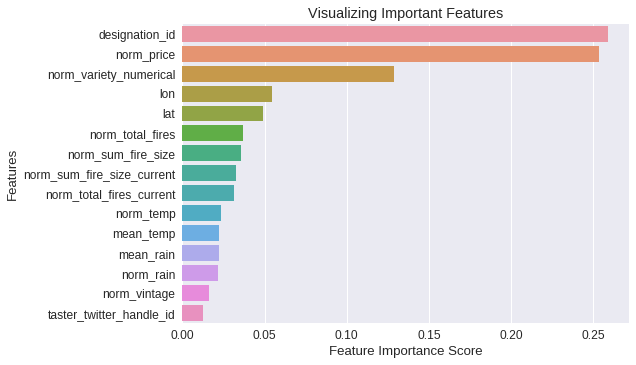

In [0]:
feature_imp = pd.Series(clf.feature_importances_,index=x_name).sort_values(ascending=False)
feature_imp

sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

After some more investigation of our data we decided to try and use the count of words in the reviews we got during the beautiful soup web scraping step. We added this latent variable to our data set and re ran the model to see how this affected our accuracy. Below we are using the gini Criterion. 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
No handles with labels found to put in legend.


Average accuracy for Gini criterion: 0.5960365853658536

Feature importance: 
review_words                  0.243983
norm_price                    0.189109
norm_reviews                  0.137375
norm_variety_numerical        0.107480
norm_sum_fire_size            0.052067
norm_ratings                  0.049108
norm_sum_fire_size_current    0.048809
norm_total_fires_current      0.043380
mean_rain                     0.028127
norm_temp                     0.026787
mean_temp                     0.026499
norm_rain                     0.025654
norm_vintage                  0.021620
dtype: float64


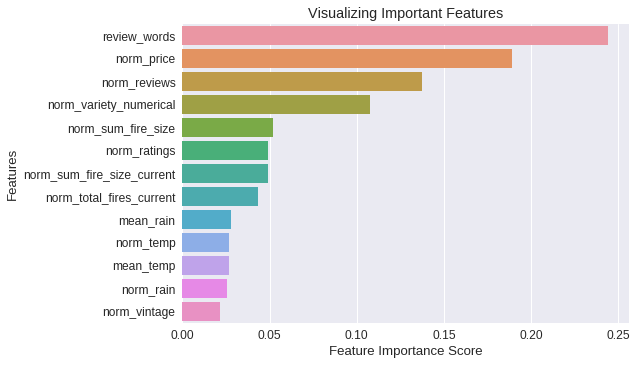


precision
0.5955201386927568
recall
0.5960365853658537
f1 score
0.5957502369202916


cross validation using 5:
[0.64231355 0.60670732 0.63414634 0.64580153 0.60703364]




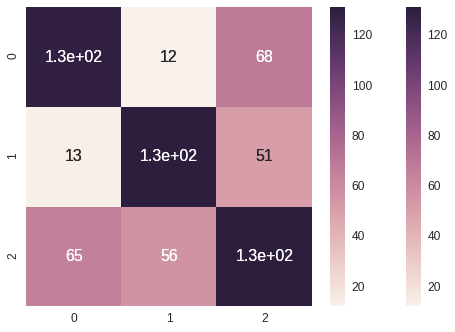

In [0]:
# setting up the model and variables including our latent variable 'review words'.

X=data[['review_words','norm_ratings','norm_reviews','norm_variety_numerical', 'norm_price', 'norm_vintage', 'norm_total_fires_current', 'norm_sum_fire_size_current', 'norm_sum_fire_size', 'mean_temp','mean_rain',	'norm_temp',	'norm_rain']]  # Features
y=data['point_bin']  # Labels
x_name = (['review_words', 'norm_ratings','norm_reviews', 'norm_variety_numerical', 'norm_price','norm_vintage', 'norm_total_fires_current', 'norm_sum_fire_size_current',  'norm_sum_fire_size', 'mean_temp','mean_rain','norm_temp','norm_rain'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
acc = 0
loop = 20
for i in range(loop):
  clf=RandomForestClassifier(n_estimators=100, random_state=10,)
  clf.fit(X_train,y_train)
  y_pred=clf.predict(X_test)
  acc += metrics.accuracy_score(y_test, y_pred)
  #print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
tot_acc = acc/20
print ("Average accuracy for Gini criterion: " + str(tot_acc) + "\n")

feature_imp = pd.Series(clf.feature_importances_,index=x_name).sort_values(ascending=False)
print ("Feature importance: \n" + str(feature_imp))

sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

conf_mat = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(conf_mat, range(3), range(3))
conf_mat

sns.set(font_scale=1.2)#for label size
sns.heatmap(conf_mat, annot=True,annot_kws={"size": 16})# font size

model_stats(y_test, y_pred)
print ("cross validation using 5:")
print(cross_val_score(clf, X ,y , cv = 5))
print("\n")

Running the model using Entropy criterion. 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
No handles with labels found to put in legend.


Average accuracy for entropy criterion: 0.6067073170731708

Feature importance: 
review_words                  0.239025
norm_price                    0.188218
norm_reviews                  0.141718
norm_variety_numerical        0.100890
norm_sum_fire_size            0.051265
norm_sum_fire_size_current    0.050719
norm_ratings                  0.048108
norm_total_fires_current      0.044480
mean_temp                     0.030001
norm_temp                     0.028949
mean_rain                     0.028267
norm_rain                     0.025616
norm_vintage                  0.022742
dtype: float64


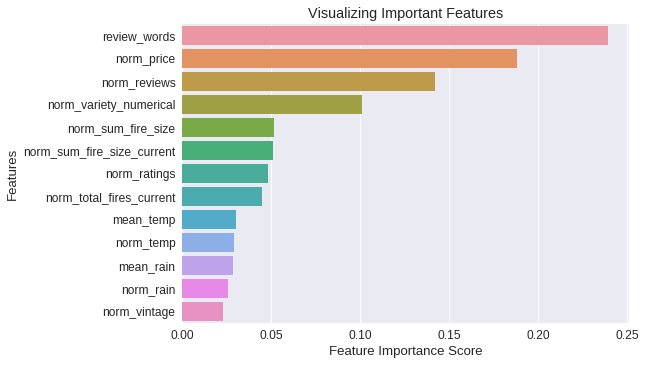


precision
0.6124097933315665
recall
0.6067073170731707
f1 score
0.6088377118939284


cross validation using 5:
[0.63926941 0.62195122 0.64481707 0.64885496 0.60397554]




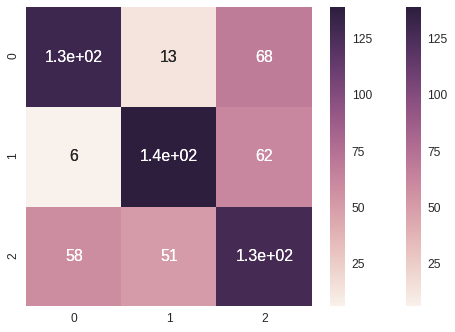

In [0]:
# setting up the model and variables including our latent variable 'review words' using gini model mode. 

X=data[['review_words','norm_ratings','norm_reviews','norm_variety_numerical', 'norm_price', 'norm_vintage', 'norm_total_fires_current', 'norm_sum_fire_size_current', 'norm_sum_fire_size', 'mean_temp','mean_rain',	'norm_temp',	'norm_rain']]  # Features
y=data['point_bin']  # Labels
x_name = (['review_words', 'norm_ratings','norm_reviews', 'norm_variety_numerical', 'norm_price','norm_vintage', 'norm_total_fires_current', 'norm_sum_fire_size_current',  'norm_sum_fire_size', 'mean_temp','mean_rain','norm_temp','norm_rain'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
acc = 0
loop = 20
for i in range(loop):
  clf=RandomForestClassifier(n_estimators=100, random_state=10, criterion='entropy')
  clf.fit(X_train,y_train)
  y_pred=clf.predict(X_test)
  acc += metrics.accuracy_score(y_test, y_pred)
  #print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
tot_acc = acc/20
print ("Average accuracy for entropy criterion: " + str(tot_acc) + "\n")

feature_imp = pd.Series(clf.feature_importances_,index=x_name).sort_values(ascending=False)
print ("Feature importance: \n" + str(feature_imp))

sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

conf_mat = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(conf_mat, range(3), range(3))
conf_mat

sns.set(font_scale=1.2)#for label size
sns.heatmap(conf_mat, annot=True,annot_kws={"size": 16})# font size

model_stats(y_test, y_pred)
print ("cross validation using 5:")
print(cross_val_score(clf, X ,y , cv = 5))
print("\n")


Using the Gini score provided from the model using the gini criterion the above model. We remove some of the lower ranked features and re run the model trying to increase the accuracy above 60%. 



/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
No handles with labels found to put in legend.


Accuracy: 0.625
review_words                  0.207695
norm_price                    0.158917
designation_id                0.133027
norm_reviews                  0.115003
norm_variety_numerical        0.087186
norm_sum_fire_size_current    0.059145
norm_sum_fire_size            0.059086
norm_total_fires_current      0.053653
mean_rain                     0.043849
mean_temp                     0.043808
norm_ratings                  0.038632
dtype: float64


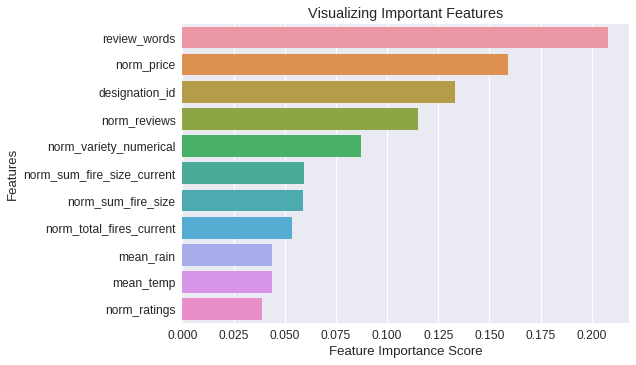

In [0]:
X=data[['review_words','norm_ratings','norm_reviews','norm_variety_numerical', 'norm_price', 'designation_id',  'norm_total_fires_current', 'norm_sum_fire_size_current', 'norm_sum_fire_size', 'mean_temp','mean_rain']]  # Features
y=data['point_bin']  # Labels
x_name = (['review_words', 'norm_ratings','norm_reviews','norm_variety_numerical', 'norm_price', 'designation_id',  'norm_total_fires_current', 'norm_sum_fire_size_current', 'norm_sum_fire_size', 'mean_temp','mean_rain'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
acc = 0
for i in range(20):
  clf=RandomForestClassifier(n_estimators=100, random_state=10)
  clf.fit(X_train,y_train)
  y_pred=clf.predict(X_test)
  acc += metrics.accuracy_score(y_test, y_pred)
  #print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
tot_acc = acc/20

print ("Accuracy: " + str(tot_acc))
feature_imp = pd.Series(clf.feature_importances_,index=x_name).sort_values(ascending=False)
print (feature_imp)

sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()


Using seaborn to create a bar plot that has the feature importance score from the model to visualize the data. 

Based on the above plot it looks like there are 4 or 5 key features that are determined by the model to be important. So to investigate this further and to look for possible latent variables we have created a correlation_coeff function that we are using to see if this helps to improve the accuracy of our model. We are creating a polynomial equation that takes the key important features and multiplies them by their respective importance score and then adding them all together. See the below equation. 

In [0]:
data['correlation_coeff'] = ((data[str(feature_imp.index[0])] * feature_imp[0])**4 + (data[str(feature_imp.index[1])] * feature_imp[1])**3 + (data[str(feature_imp.index[2])] * feature_imp[2])**2 + (data[str(feature_imp.index[3])] * feature_imp[3]))




Below we are now taking all the important features as well as the new correlation_coeff function we created above, and are going to run this through the random forest model and see if there is any improvement to the accuracy of the model. We are again splitting the data into testing and into training. 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
No handles with labels found to put in legend.


Accuracy: 0.6234756097560974

correlation_coeff    0.321895
review_words         0.256871
norm_price           0.250666
mean_temp            0.170567
dtype: float64


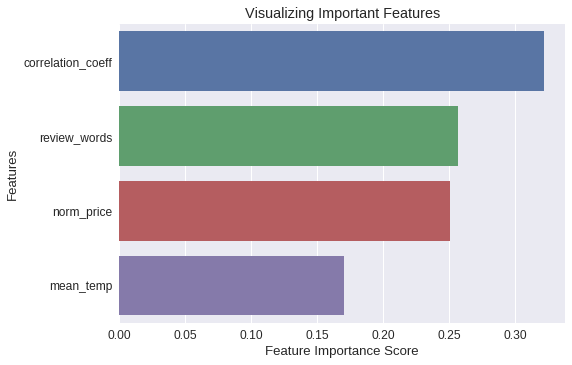


precision
0.6246377513312885
recall
0.6234756097560976
f1 score
0.6237204235585616


cross validation using 5:
[0.56925419 0.58689024 0.58689024 0.61984733 0.57186544]




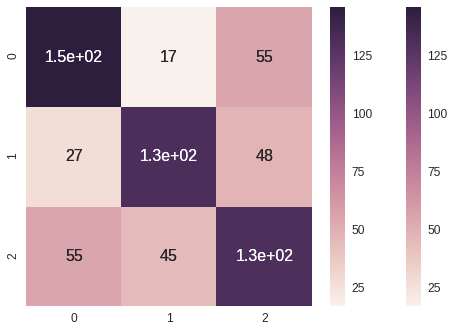

In [0]:
# Split dataset into features and labels
X=data[['correlation_coeff', 'mean_temp', 'review_words', 'norm_price']]  # Features
y=data['point_bin']  # Labels
x_name = (['correlation_coeff',  'mean_temp', 'review_words', 'norm_price'])
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10) # 80% training and 20% test


acc = 0
for i in range(20):
  clf=RandomForestClassifier(n_estimators=100, random_state=10)
  clf.fit(X_train,y_train)
  y_pred=clf.predict(X_test)
  acc += metrics.accuracy_score(y_test, y_pred)
  #print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
tot_acc = acc/20

print ("Accuracy: " + str(tot_acc) + "\n")
feature_imp = pd.Series(clf.feature_importances_,index=x_name).sort_values(ascending=False)
print (feature_imp)


sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

conf_mat = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(conf_mat, range(3), range(3))
conf_mat

sns.set(font_scale=1.2)#for label size
sns.heatmap(conf_mat, annot=True,annot_kws={"size": 16})# font size

model_stats(y_test, y_pred)
print ("cross validation using 5:")
print(cross_val_score(clf, X ,y , cv = 5))
print("\n")


Below we are again looking at all the important features to see how the features are effecting the prediction of the points of the wine. 

Now that we have the model finished we will run the confusion matrix and model scoreing functions to see how well the model performed. 

##Analysis- Randon Forest

This was a very useful and important model because we were able to gain valuable information into what the model thinks is the most important features. We were able to increase our overall prediction accuracy to about 62%. 

To get this percentage increase we had to look for a latent variable that ended up being a combination of the the top 4 important features determined by the the random forest model. We then created a simple polynomial equation, we then took that polynomial and applied it to the random forest model to see how much of an effect this new latent variable, called 'correction_coeff',  had on the prediction accuracy. Alone this feature gave about a 55% percent accurate prediction of the target feature, points. So then to further increase this percentage we added a few more of the other important features to the random forest classification to see if the combination of just the top features helped with the overall accuracy. This indeed helped with the prediction accuracy, we were able to get the model to about 62%. So overall random forest was a very powerful model to use for this project.

# Conclusion

|   | Accuracy  | Precision  | f1 score  |
|---|---|---|---|---|
| Linear Regression  |0.2642    |  N/A | N/A  |
| Logisitic Regression | 0.6668 |  0.6666 | 0.6662  |
| Naive Bayes  | 0.4740  |  0.4667 | 0.3937  |
| Decision Tree  | 0.4054  |  0.4070 | 0.4006 |   
| Random Forest  | 0.6234  | 0.6246  | 0.6237  |   




---


Here, we compile our results from all our algorithms for prediction. As we can see, logisitic regression has the highest accuracy, but we limited the output to only 2 classes, good wine and bad wine. Our best algorithm to predict the rating of the wines is random forest using our correlation coefficient built from our polynomial equation. 


To recap our business objectives, as a customer, we wanted to find cheap and highly rated wines to purchase. We wanted to create a tool that allows the average person, like us, the ability to enter some key features and get a recomendation. On the other side of this, as a business owner and the primary focus of the project, we wanted to predict the ratings of a new wine and be able to change factors like the type of grapes or the price to try to increase the wine's rating. We invision this being a useful tool for wine makers as it will give them a predicion of how their new wine will be preceived by both the wine reviews and the public.  This is a useful business tool in that it could help guide growers choose a grape type that has a higher probability to be rated well vs other types of grapes. This will help with overall profitability over the lifecycle of the winery. 


From our clustering, we achieved our customer business objective, as we were able to find cheap and highly rated wines from our clustering. A customer could pick any wine within that cluster to fullfill their needs. This tool has a relatively low computational footprint and a user could feasibily run this from an app on their phone. The target users would be people who are looking for something with a particular profile and get a grouping of wines that both fit the profile and budget. We recognize that there is a notion that the more expensive wines are the best and that the cheaper wines, are well just that, cheap. With this tool we can give a wine that is both highly rated and that is also within budget.  


From our random forest, we got close to fullfilling our business objective. The random forest has the highest accuracy of all the prediction capable algorithms we implemented, and a business can use it to predict the rating of a new wine. A business can also study the input features to the random forest and change them to try to increase the rating. This model gives the flexability for a winery to enter and tweek parameters, such as variety, environmental factors, vintage ect.  to generate a prediction of how that simulated wine will be rated. This is a great help to the business because instead of needing to physically growing, harvesting, botteling, aging, and going through the review process to get the rating, they could use this model and get a predicted rating. 


We also need to mention that this prediction model is not 100% accurate and there is definite room for improvement. This is not a final product. However in the time and resources that we had to deliver this project, we believe that this model is more then a proof of concept and it shows the feasability of a wine rating prediction tool. We have shown the fesability for model implementation for both the consumer and business space. 